# EDA

 - Correlation Analysis
 - ACF/PACF
 - MI

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import pytz

from scipy.stats import skew, kurtosis
import gzip
import pyarrow.parquet as pq
import pytz
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

## Data Preprocess

In [ ]:
def get_delivery_time(df):
    df['weekday_num'] = df['ExecutionTime'].dt.weekday
    df['ID_weekday_num'] = df['ID'].str[:3]
    df['ID_weekday_num'] = df['ID_weekday_num'].replace({'Mon':0, 'Tue':1, 'Wed':2,
                                                         'Thu':3, 'Fri':4, 'Sat':5, 'Sun':6})
    df['days_to_add'] = (df['ID_weekday_num'] - df['weekday_num'])%7
    df['delivery_date'] = df['ExecutionTime'].dt.date + pd.to_timedelta(df['days_to_add'],unit='d')
    hours = df['ID'].str[3:5].astype(int)
    minutes = ((df['ID'].str[-1].astype(int) - 1) * 15)
    df['delivery_time'] = pd.to_datetime(df['delivery_date']) + pd.to_timedelta(hours, unit='h') + pd.to_timedelta(minutes, unit='m')
    df = df[['ExecutionTime', 'ID', 'high', 'low', 'close', 'volume','delivery_date', 'delivery_time']]
    return df


def rename_variables(df_variables):
    df_variables['wind_actual'] = df_variables['generation_wind_offshore_actual'] + df_variables['generation_wind_onshore_actual']
    df_variables['wind_forecast'] = df_variables['generation_wind_offshore_forecast'] + df_variables['generation_wind_onshore_forecast']
    df_variables = df_variables.rename(columns={"generation_solar_actual":"solar_actual", "generation_solar_forecast": "solar_forecast"})
    df_variables = df_variables.drop(columns=['generation_wind_offshore_actual', 'generation_wind_onshore_actual', 'generation_wind_offshore_forecast', 'generation_wind_onshore_forecast','delivery_time'])
    return df_variables


def generate_lag_variables(df_raw,specified_hour, max_neighbors=3):

    # Step 1: Preprocess
    df = df_raw.copy()
    df['delivery_time'] = pd.to_datetime(df['delivery_time'])
    #df = df[['ExecutionTime', 'delivery_time', 'close', 'day_ahead_price']]
    df['execution_hour'] = df['ExecutionTime'].dt.floor('h')

    # Step 2: Compute execution hour ranges
    start_exec = df.groupby('delivery_time')['ExecutionTime'].min().dt.floor('h') + pd.Timedelta(hours=3)
    end_exec = df.groupby('delivery_time')['delivery_time'].first().apply(lambda x: (x - pd.Timedelta(minutes=15)).floor('h'))
    exec_range_df = pd.DataFrame({
        'delivery_time': start_exec.index,
        'start_hour': start_exec.values,
        'end_hour': end_exec.values
    })

    # Step 3: Construct target sample rows
    sample_rows = []
    for _, row in exec_range_df.iterrows():
        d_time, start, end = row['delivery_time'], row['start_hour'], row['end_hour']
        if end < start:
            continue
        for exec_hour in pd.date_range(start, end, freq='h'):
            sample_rows.append({'delivery_time': d_time, 'execution_hour': exec_hour})
    target_df = pd.DataFrame(sample_rows)

    # Step 4: Attach target close price
    hourly_close = df[df['ExecutionTime'].dt.minute == 0][['delivery_time', 'execution_hour', 'close']]
    hourly_close = hourly_close.rename(columns={'close': 'target_close'})
    target_df = target_df.merge(hourly_close, on=['delivery_time', 'execution_hour'], how='left')

    # Step 5: Preload quarter-level lookups
    df['quarter_hour'] = df['ExecutionTime']
    close_map = df.set_index(['delivery_time', 'quarter_hour'])['close'].to_dict()
    volume_map = df.set_index(['delivery_time', 'quarter_hour'])['volume'].to_dict()

    df['delivery_hour'] = df['delivery_time'].dt.floor('h')
    delivery_to_neighbors = (
        df[['delivery_time', 'delivery_hour']]
        .drop_duplicates()
        .groupby('delivery_hour')['delivery_time']
        .apply(list)
        .to_dict()
    )

    # Step 6: Feature extractor
    def extract_features(delivery_time, execution_hour):
        features = {}
        # current contract
        for i in range(specified_hour):
            t = execution_hour - pd.Timedelta(minutes=15 * (specified_hour - i))
            features[f'tgt_close_t-{specified_hour - i}'] = close_map.get((delivery_time, t), np.nan)
            features[f'tgt_volume_t-{specified_hour - i}'] = volume_map.get((delivery_time, t), np.nan)


        # neighbors
        d_hour = delivery_time.floor('h')
        neighbors = [d for d in delivery_to_neighbors.get(d_hour, []) if d != delivery_time]
        for j, neigh in enumerate(neighbors[:max_neighbors]):
            t = execution_hour - pd.Timedelta(minutes=15)
            features[f'neigh{j+1}_close_t-15min'] = close_map.get((neigh, t), np.nan)

        d_hour = delivery_time.floor('h')
        neighbors = [d for d in delivery_to_neighbors.get(d_hour, []) if d != delivery_time]
        for j, neigh in enumerate(neighbors[:max_neighbors]):
            for i in range(specified_hour):
                t = execution_hour - pd.Timedelta(minutes=15 * (specified_hour - i))
                features[f'neigh{j+1}_close_t-{specified_hour - i}'] = close_map.get((neigh, t), np.nan)

        return features

    # Step 7: Apply
    all_feature_rows = []
    for row in target_df.itertuples():
        f_row = extract_features(row.delivery_time, row.execution_hour)
        f_row.update({
            'delivery_time': row.delivery_time,
            'execution_hour': row.execution_hour,
            'target_close': row.target_close
        })
        all_feature_rows.append(f_row)

    result = pd.DataFrame(all_feature_rows)


    return result


def add_temproal_features(df):
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['delivery_time'].dt.dayofyear  / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['delivery_time'].dt.dayofyear / 365)
    df['delivery_hour'] = df['delivery_time'].dt.hour
    df['delivery_hour_sin'] = np.sin(df['delivery_time'].dt.hour * (2 * np.pi / 24))
    df['delivery_hour_cos'] = np.cos(df['delivery_time'].dt.hour * (2 * np.pi / 24))
    df['delivery_weekday_sin'] = np.sin(df['delivery_time'].dt.weekday * (2 * np.pi / 7))
    df['delivery_weekday_cos'] = np.cos(df['delivery_time'].dt.weekday * (2 * np.pi / 7))
    df['delivery_month_sin'] = np.sin(df['delivery_time'].dt.month * (2 * np.pi / 12))
    df['delivery_month_cos'] = np.cos(df['delivery_time'].dt.month * (2 * np.pi / 12))
    df['time_to_expiry_h'] = (df['delivery_time'] - df['execution_hour']).dt.total_seconds() / 3600.0
    return df


In [ ]:
df_train = pd.read_parquet('train_fullyears.parquet')
test_2024 = pd.read_parquet('test_2024.parquet')
df_variables = pd.read_parquet('df_train_variables.parquet')
df_test_variables = pd.read_parquet('df_test_variables.parquet')

df_train['ExecutionTime'] = df_train['ExecutionTime'].dt.tz_localize(None)
test_2024['ExecutionTime'] = test_2024['ExecutionTime'].dt.tz_localize(None)

df_train_2023 = df_train[df_train['ExecutionTime'].dt.year==2023]
value_cols = [c for c in df_train_2023.columns if c not in ['ID', 'ExecutionTime','delivery_time','delivery_date']]
df_train_2023 = (df_train_2023.groupby(['ID', 'ExecutionTime'], as_index=False)[value_cols].mean())
df_train_2023 = get_delivery_time(df_train_2023)
df_variables = rename_variables(df_variables)

In [ ]:
# generate executiontime-15min wind,solar,load actual value
df_train_2023['timestamp'] = df_train_2023['ExecutionTime'] - pd.Timedelta(minutes=15)
df_train_2023_wide_exc = df_train_2023.merge(
    df_variables[['timestamp', 'wind_actual', 'solar_actual', 'load_actual']],
    on='timestamp',
    how='left'
).rename(columns={'wind_actual': 'wind_actual_exc-15m', 'solar_actual': 'solar_actual_exc-15m', 'load_actual': 'load_actual_exc-15m'})
df_train_2023_wide_exc = df_train_2023_wide_exc.drop(columns='timestamp')
df_train_2023_wide_exc.head()


,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m
0,2023-01-05 15:30:00,Fri00Q1,133.43,97.22,133.43,0.05,2023-01-06,2023-01-06,20700.0,1385.0,60609.0
1,2023-01-05 15:45:00,Fri00Q1,123.55,123.55,123.55,0.25,2023-01-06,2023-01-06,19580.0,925.0,60260.0
2,2023-01-05 16:00:00,Fri00Q1,133.43,133.43,133.43,0.10,2023-01-06,2023-01-06,18724.0,502.0,59955.0
3,2023-01-05 16:15:00,Fri00Q1,133.43,133.43,133.43,0.00,2023-01-06,2023-01-06,18026.0,215.0,60139.0
4,2023-01-05 16:30:00,Fri00Q1,133.43,133.43,133.43,0.00,2023-01-06,2023-01-06,17261.0,56.0,60389.0


In [ ]:
# generate lag 12 price and neighbour contract lag price, as well as merge with variables to get day_ahead_price
df_train_2023_wide = generate_lag_variables(df_train_2023, specified_hour=12)
df_train_2023_wide = pd.merge(df_train_2023_wide, df_variables[['timestamp', 'day_ahead_price','temperature_rounded','imported','exported']], left_on='delivery_time', right_on='timestamp', how='left')
df_train_2023_wide = df_train_2023_wide.sort_values(by=['delivery_time','execution_hour']).reset_index(drop=True)
df_train_2023_wide = df_train_2023_wide.drop(columns=['timestamp'])
df_train_2023_wide = df_train_2023_wide.merge(df_train_2023_wide_exc[['delivery_time','ExecutionTime','wind_actual_exc-15m', 'solar_actual_exc-15m', 'load_actual_exc-15m']], left_on=['delivery_time','execution_hour'],
                                            right_on =['delivery_time','ExecutionTime'], how='left')
print(df_train_2023_wide.shape)
df_train_2023_wide.head()

(598386, 74)


,tgt_close_t-12,tgt_volume_t-12,tgt_close_t-11,tgt_volume_t-11,tgt_close_t-10,tgt_volume_t-10,tgt_close_t-9,tgt_volume_t-9,tgt_close_t-8,tgt_volume_t-8,...,execution_hour,target_close,day_ahead_price,temperature_rounded,imported,exported,ExecutionTime,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m
0,-4.99,4.375,-7.99,3.375,-4.70,3.725,-7.30,0.800,-3.38,6.850,...,2023-01-01 03:00:00,-5.94,-29.93,11.1975,0.0,5619.0,2023-01-01 03:00:00,33406.0,2.0,36932.0
1,-8.20,5.850,-7.21,3.300,-6.84,1.700,-9.00,3.875,-7.44,8.925,...,2023-01-01 03:00:00,-1.80,-29.94,11.2650,0.0,5619.0,2023-01-01 03:00:00,33406.0,2.0,36932.0
2,-9.87,2.625,-9.89,2.775,-8.37,1.875,-3.71,3.425,-0.11,13.625,...,2023-01-01 03:00:00,NaN,-29.94,11.3325,0.0,5619.0,NaT,NaN,NaN,NaN
3,-5.00,0.000,-5.00,0.000,-1.64,0.300,-5.13,4.800,-2.00,7.200,...,2023-01-01 03:00:00,-5.23,-29.90,11.4000,0.0,4563.6,2023-01-01 03:00:00,33406.0,2.0,36932.0
4,-3.64,0.325,-3.80,2.075,-3.99,0.100,-3.83,4.000,NaN,NaN,...,2023-01-01 03:00:00,-2.28,-29.93,11.4625,0.0,4563.6,2023-01-01 03:00:00,33406.0,2.0,36932.0


In [ ]:
# Add generation and load forecast and actual value based on delievry time
forecast_cols = {
    'wind_forecast': [
        (0, 0), (0, 15), (0, 30), (0, 45), (0, 60),
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'solar_forecast': [
        (0, 0), (0, 15), (0, 30), (0, 45), (0, 60),
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'load_forecast': [
        (0, 0), (0, 15), (0, 30), (0, 45), (0, 60),
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'wind_actual': [
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'solar_actual': [
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'load_actual': [
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ]
}

df_result = df_train_2023_wide[['delivery_time']].drop_duplicates().copy()

for var, offsets in forecast_cols.items():
    for days, minutes in offsets:
        prefix = var.replace('generation_', '').replace('_forecast', '').replace('_actual', '')
        label = f"{prefix}_{'actual' if 'actual' in var else 'forecast'}_t-{'1d-' if days==1 else ''}{minutes}m"

        ts = df_train_2023_wide['delivery_time'] - pd.Timedelta(days=days, minutes=minutes)

        df_temp = pd.DataFrame({
            'delivery_time': df_train_2023_wide['delivery_time'],
            'timestamp': ts
        })

        df_temp = df_temp.merge(
            df_variables[['timestamp', var]],
            on='timestamp',
            how='left'
        ).rename(columns={var: label})

        df_result[label] = df_temp[label]

df_result = df_result.sort_values(by='delivery_time').reset_index(drop=True)
df_result.head()


,delivery_time,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,...,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m
0,2023-01-01 03:15:00,37772.0,38397.0,38460.0,38513.0,38560.0,31733.0,32054.0,32443.0,32824.0,...,5.0,5.0,5.0,5.0,4.0,36932.0,36711.0,36612.0,37009.0,37179.0
1,2023-01-01 03:30:00,37683.0,37772.0,38397.0,38460.0,38513.0,31372.0,31733.0,32054.0,32443.0,...,5.0,5.0,5.0,5.0,5.0,36724.0,36932.0,36711.0,36612.0,37009.0
2,2023-01-01 03:45:00,37585.0,37683.0,37772.0,38397.0,38460.0,31013.0,31372.0,31733.0,32054.0,...,5.0,5.0,5.0,5.0,5.0,36693.0,36724.0,36932.0,36711.0,36612.0
3,2023-01-01 04:00:00,37486.0,37585.0,37683.0,37772.0,38397.0,30664.0,31013.0,31372.0,31733.0,...,5.0,5.0,5.0,5.0,5.0,36850.0,36693.0,36724.0,36932.0,36711.0
4,2023-01-01 04:15:00,37390.0,37486.0,37585.0,37683.0,37772.0,30489.0,30664.0,31013.0,31372.0,...,5.0,5.0,5.0,5.0,5.0,37122.0,36850.0,36693.0,36724.0,36932.0


In [ ]:
t =df_train_2023_wide.merge(df_result, on='delivery_time', how='left')
t = add_temproal_features(t)
t.head()

,tgt_close_t-12,tgt_volume_t-12,tgt_close_t-11,tgt_volume_t-11,tgt_close_t-10,tgt_volume_t-10,tgt_close_t-9,tgt_volume_t-9,tgt_close_t-8,tgt_volume_t-8,...,day_of_year_sin,day_of_year_cos,delivery_hour,delivery_hour_sin,delivery_hour_cos,delivery_weekday_sin,delivery_weekday_cos,delivery_month_sin,delivery_month_cos,time_to_expiry_h
0,-4.99,4.375,-7.99,3.375,-4.70,3.725,-7.30,0.800,-3.38,6.850,...,0.017213,0.999852,3,0.707107,0.707107,-0.781831,0.62349,0.5,0.866025,0.25
1,-8.20,5.850,-7.21,3.300,-6.84,1.700,-9.00,3.875,-7.44,8.925,...,0.017213,0.999852,3,0.707107,0.707107,-0.781831,0.62349,0.5,0.866025,0.50
2,-9.87,2.625,-9.89,2.775,-8.37,1.875,-3.71,3.425,-0.11,13.625,...,0.017213,0.999852,3,0.707107,0.707107,-0.781831,0.62349,0.5,0.866025,0.75
3,-5.00,0.000,-5.00,0.000,-1.64,0.300,-5.13,4.800,-2.00,7.200,...,0.017213,0.999852,4,0.866025,0.500000,-0.781831,0.62349,0.5,0.866025,1.00
4,-3.64,0.325,-3.80,2.075,-3.99,0.100,-3.83,4.000,NaN,NaN,...,0.017213,0.999852,4,0.866025,0.500000,-0.781831,0.62349,0.5,0.866025,1.25


## Correlation Analysis

In [ ]:
def corr_analysis(df, group_by):
    corr = (
        df.groupby(group_by)
        .apply(lambda g: g.corr(method="pearson")["target_close"].drop("target_close"))
    )
    return corr

def highlight_row(row):
    abs_vals = row.abs()
    max_val = abs_vals.max()
    return [
        f"background-color: hsl({(v/max_val)*120}, 70%, 70%)"
        for v in abs_vals
    ]


In [ ]:
lws_forecast_cols = [
 'wind_forecast_t-0m', 'wind_forecast_t-15m', 'wind_forecast_t-30m','wind_forecast_t-45m','wind_forecast_t-60m','wind_forecast_t-1d-0m',
 'wind_forecast_t-1d-15m','wind_forecast_t-1d-30m','wind_forecast_t-1d-45m','wind_forecast_t-1d-60m','solar_forecast_t-0m',
 'solar_forecast_t-15m','solar_forecast_t-30m','solar_forecast_t-45m','solar_forecast_t-60m','solar_forecast_t-1d-0m','solar_forecast_t-1d-15m',
 'solar_forecast_t-1d-30m','solar_forecast_t-1d-45m','solar_forecast_t-1d-60m','load_forecast_t-0m','load_forecast_t-15m','load_forecast_t-30m',
 'load_forecast_t-45m','load_forecast_t-60m','load_forecast_t-1d-0m','load_forecast_t-1d-15m','load_forecast_t-1d-30m','load_forecast_t-1d-45m',
 'load_forecast_t-1d-60m']

lws_actual_cols = [
'wind_actual_exc-15m','solar_actual_exc-15m','load_actual_exc-15m','wind_actual_t-1d-0m', 'wind_actual_t-1d-15m', 'wind_actual_t-1d-30m',
 'wind_actual_t-1d-45m','wind_actual_t-1d-60m', 'solar_actual_t-1d-0m', 'solar_actual_t-1d-15m', 'solar_actual_t-1d-30m', 'solar_actual_t-1d-45m',
 'solar_actual_t-1d-60m', 'load_actual_t-1d-0m', 'load_actual_t-1d-15m', 'load_actual_t-1d-30m', 'load_actual_t-1d-45m', 'load_actual_t-1d-60m']

nbr_cols = [
'neigh1_close_t-12', 'neigh1_close_t-11', 'neigh1_close_t-10', 'neigh1_close_t-9', 'neigh1_close_t-8', 'neigh1_close_t-7', 'neigh1_close_t-6',
 'neigh1_close_t-5', 'neigh1_close_t-4', 'neigh1_close_t-3', 'neigh1_close_t-2', 'neigh1_close_t-1', 'neigh2_close_t-12', 'neigh2_close_t-11',
 'neigh2_close_t-10', 'neigh2_close_t-9', 'neigh2_close_t-8', 'neigh2_close_t-7', 'neigh2_close_t-6', 'neigh2_close_t-5', 'neigh2_close_t-4',
 'neigh2_close_t-3', 'neigh2_close_t-2', 'neigh2_close_t-1', 'neigh3_close_t-12', 'neigh3_close_t-11', 'neigh3_close_t-10', 'neigh3_close_t-9',
 'neigh3_close_t-8', 'neigh3_close_t-7', 'neigh3_close_t-6', 'neigh3_close_t-5', 'neigh3_close_t-4', 'neigh3_close_t-3', 'neigh3_close_t-2',
 'neigh3_close_t-1']

other_cols = [
    'day_ahead_price','time_to_expiry_h', 'temperature_rounded', 'exported', 'imported', 'delivery_month_sin', 'delivery_month_cos', 'delivery_weekday_sin',
 'delivery_weekday_cos', 'day_of_year_sin', 'day_of_year_cos']

tgt_cols = [
'tgt_close_t-12','tgt_close_t-11','tgt_close_t-10','tgt_close_t-9','tgt_close_t-8',
'tgt_close_t-7','tgt_close_t-6','tgt_close_t-5','tgt_close_t-4','tgt_close_t-3',
'tgt_close_t-2','tgt_close_t-1',
'tgt_volume_t-12','tgt_volume_t-11','tgt_volume_t-10','tgt_volume_t-9','tgt_volume_t-8',
'tgt_volume_t-7','tgt_volume_t-6','tgt_volume_t-5','tgt_volume_t-4','tgt_volume_t-3',
'tgt_volume_t-2','tgt_volume_t-1',
]

In [ ]:
t_corr = corr_analysis(t, 'delivery_hour')

In [ ]:
tgt_lag_corr = t_corr[tgt_cols]
tgt_lag_corr_s = tgt_lag_corr.style.apply(highlight_row, axis=1)
tgt_lag_corr_s

target_close,tgt_close_t-12,tgt_close_t-11,tgt_close_t-10,tgt_close_t-9,tgt_close_t-8,tgt_close_t-7,tgt_close_t-6,tgt_close_t-5,tgt_close_t-4,tgt_close_t-3,tgt_close_t-2,tgt_close_t-1,tgt_volume_t-12,tgt_volume_t-11,tgt_volume_t-10,tgt_volume_t-9,tgt_volume_t-8,tgt_volume_t-7,tgt_volume_t-6,tgt_volume_t-5,tgt_volume_t-4,tgt_volume_t-3,tgt_volume_t-2,tgt_volume_t-1
delivery_hour,,,,,,,,,,,,,,,,,,,,,,,,
0,0.887332,0.911383,0.922570,0.928423,0.940951,0.947844,0.953291,0.958603,0.967483,0.975034,0.981276,0.990797,-0.094721,-0.089741,-0.088639,-0.131704,-0.096926,-0.086195,-0.101447,-0.093709,-0.089520,-0.125193,-0.103192,-0.027949
1,0.925564,0.932011,0.938066,0.943101,0.951360,0.958465,0.963300,0.966862,0.976035,0.982536,0.987532,0.990945,-0.067129,-0.083404,-0.079315,-0.086262,-0.064758,-0.084516,-0.089324,-0.093140,-0.077868,-0.102423,-0.092408,-0.038226
2,0.916618,0.918846,0.924293,0.943025,0.955407,0.962265,0.966448,0.970615,0.977105,0.983633,0.988555,0.992574,-0.066143,-0.095744,-0.112397,-0.107777,-0.094988,-0.112033,-0.119540,-0.088151,-0.092089,-0.103326,-0.092790,-0.051402
3,0.948988,0.950757,0.954248,0.956880,0.964452,0.970086,0.973153,0.976382,0.981729,0.986526,0.990503,0.993885,-0.083571,-0.089438,-0.082706,-0.092085,-0.105661,-0.101412,-0.091087,-0.075964,-0.106674,-0.092267,-0.076048,-0.054745
4,0.929192,0.950796,0.955106,0.957654,0.964479,0.968510,0.971673,0.975571,0.982154,0.986296,0.989334,0.993392,-0.036602,-0.051160,-0.040241,-0.014392,-0.057728,-0.057011,-0.049511,-0.019810,-0.060324,-0.045546,-0.041987,-0.041868
5,0.934613,0.950187,0.953619,0.956609,0.963924,0.968881,0.972266,0.975792,0.981465,0.986015,0.990046,0.993813,-0.023407,-0.018499,-0.019565,0.011877,-0.041678,-0.022049,-0.020898,0.014181,-0.026988,0.001332,-0.007122,-0.023543
6,0.923959,0.928843,0.932384,0.935357,0.942360,0.946431,0.949864,0.953508,0.964846,0.977907,0.987651,0.992086,0.007995,0.020159,0.040850,0.064313,0.003100,0.026269,0.037373,0.049933,0.010234,0.046421,0.033978,-0.007746
7,0.827317,0.868070,0.881076,0.887168,0.897431,0.912977,0.936774,0.942369,0.954311,0.970677,0.987528,0.991643,0.022862,0.028429,0.044891,0.030136,0.029873,0.025849,0.033838,0.011576,0.011928,0.021177,0.013632,-0.007452
8,0.946600,0.949303,0.951929,0.954943,0.960376,0.962960,0.965657,0.969332,0.976123,0.980843,0.985593,0.992358,0.003552,0.007266,-0.003102,-0.013382,-0.008425,-0.011599,-0.014058,-0.022702,-0.021964,-0.024411,-0.009681,0.024287


In [ ]:
lws_corr = t_corr[lws_forecast_cols]
lws_corr_s = lws_corr.style.apply(highlight_row, axis=1)
lws_corr_s

target_close,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m
delivery_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.663659,-0.660945,-0.656655,-0.650477,-0.642153,-0.307235,-0.304439,-0.300268,-0.294609,-0.287902,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.189165,0.193291,0.196977,0.197726,0.197095,0.176943,0.178421,0.179971,0.177404,0.173034
1,-0.681077,-0.677917,-0.675296,-0.673329,-0.671899,-0.317381,-0.312849,-0.308776,-0.305322,-0.302396,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.186630,0.189937,0.192374,0.193778,0.192750,0.180551,0.183324,0.185698,0.186260,0.184590
2,-0.695739,-0.693974,-0.691910,-0.689532,-0.686880,-0.313234,-0.310012,-0.306800,-0.303546,-0.300316,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.202442,0.203902,0.204023,0.204718,0.204665,0.197014,0.197425,0.196878,0.196855,0.196384
3,-0.708889,-0.707120,-0.705072,-0.702704,-0.700102,-0.333160,-0.330703,-0.328089,-0.325237,-0.322197,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.203939,0.205751,0.205865,0.204341,0.203300,0.200174,0.200116,0.198831,0.196203,0.193849
4,-0.697124,-0.695351,-0.693503,-0.691600,-0.689556,-0.330797,-0.329140,-0.327529,-0.325924,-0.324203,0.061164,nan,nan,nan,nan,0.064222,nan,nan,nan,nan,0.201969,0.204934,0.208347,0.208967,0.206855,0.184647,0.186105,0.187673,0.187098,0.184217
5,-0.627033,-0.625639,-0.624228,-0.622690,-0.620850,-0.298404,-0.296551,-0.294975,-0.293419,-0.291784,0.075286,0.079385,0.082961,0.087049,0.071494,0.078110,0.083764,0.085920,0.083178,0.072861,0.285357,0.282322,0.279252,0.274795,0.259853,0.201161,0.198906,0.196925,0.194804,0.183138
6,-0.499717,-0.497683,-0.496679,-0.496381,-0.496441,-0.240203,-0.237143,-0.235509,-0.235000,-0.235136,0.011745,0.011235,0.013490,0.016770,0.021576,0.014941,0.015486,0.019142,0.023878,0.029768,0.468959,0.479091,0.471277,0.447657,0.411920,0.216109,0.229537,0.228111,0.212014,0.185937
7,-0.381019,-0.383027,-0.384560,-0.385381,-0.385559,-0.159479,-0.159634,-0.159735,-0.159391,-0.158957,-0.116598,-0.127811,-0.135414,-0.139470,-0.140557,-0.109422,-0.121187,-0.129584,-0.134385,-0.135138,0.468482,0.470471,0.473686,0.473841,0.472013,0.165175,0.169017,0.172680,0.174895,0.175845
8,-0.304289,-0.304432,-0.305226,-0.306785,-0.308992,-0.088061,-0.086606,-0.085729,-0.085439,-0.085622,-0.288119,-0.301297,-0.312450,-0.321276,-0.326963,-0.270386,-0.283838,-0.295648,-0.305380,-0.312264,0.525695,0.519246,0.517717,0.516372,0.517489,0.207114,0.201379,0.200779,0.200831,0.203758


In [ ]:
nbr_corr = t_corr[nbr_cols]
nbr_corr_s = nbr_corr.style.apply(highlight_row, axis=1)
nbr_corr_s

target_close,neigh1_close_t-12,neigh1_close_t-11,neigh1_close_t-10,neigh1_close_t-9,neigh1_close_t-8,neigh1_close_t-7,neigh1_close_t-6,neigh1_close_t-5,neigh1_close_t-4,neigh1_close_t-3,neigh1_close_t-2,neigh1_close_t-1,neigh2_close_t-12,neigh2_close_t-11,neigh2_close_t-10,neigh2_close_t-9,neigh2_close_t-8,neigh2_close_t-7,neigh2_close_t-6,neigh2_close_t-5,neigh2_close_t-4,neigh2_close_t-3,neigh2_close_t-2,neigh2_close_t-1,neigh3_close_t-12,neigh3_close_t-11,neigh3_close_t-10,neigh3_close_t-9,neigh3_close_t-8,neigh3_close_t-7,neigh3_close_t-6,neigh3_close_t-5,neigh3_close_t-4,neigh3_close_t-3,neigh3_close_t-2,neigh3_close_t-1
delivery_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.772220,0.769086,0.780567,0.783536,0.793932,0.796292,0.794835,0.779804,0.784524,0.783558,0.783072,0.772634,0.750973,0.782775,0.794293,0.795412,0.806761,0.806883,0.812482,0.812184,0.818605,0.814849,0.819340,0.819006,0.768884,0.797283,0.803056,0.806139,0.812235,0.819641,0.823401,0.822412,0.826994,0.832143,0.834656,0.830283
1,0.830280,0.829550,0.835442,0.836207,0.844755,0.851974,0.853250,0.851812,0.859062,0.862818,0.865265,0.863052,0.853391,0.857792,0.861308,0.863561,0.870441,0.877098,0.879372,0.881040,0.888228,0.891449,0.893335,0.894202,0.847235,0.852959,0.855663,0.860336,0.865373,0.869651,0.872069,0.875443,0.881902,0.885401,0.886247,0.887226
2,0.856856,0.858306,0.864699,0.885093,0.893569,0.899637,0.903635,0.906662,0.909437,0.912951,0.916900,0.918953,0.863279,0.865342,0.870913,0.902967,0.913642,0.919055,0.922517,0.925340,0.931431,0.933856,0.937094,0.939045,0.892002,0.891508,0.894889,0.898039,0.908758,0.913184,0.915736,0.918892,0.924626,0.928864,0.930716,0.932404
3,0.906951,0.906394,0.910164,0.912693,0.918500,0.922665,0.924130,0.926407,0.930405,0.932510,0.934813,0.936417,0.923496,0.924231,0.926793,0.928911,0.936077,0.940433,0.942536,0.944879,0.949626,0.951415,0.953801,0.955658,0.913545,0.915507,0.916808,0.918892,0.925074,0.930069,0.931379,0.934184,0.938600,0.942175,0.943017,0.945386
4,0.884080,0.888635,0.892043,0.893255,0.896942,0.899918,0.902768,0.904744,0.908790,0.910330,0.912115,0.914139,0.882593,0.886850,0.890307,0.892294,0.897346,0.899708,0.902632,0.905715,0.911221,0.912811,0.914425,0.916540,0.867014,0.883098,0.885776,0.888050,0.892940,0.896469,0.898251,0.901159,0.905895,0.908775,0.909473,0.911263
5,0.790071,0.790044,0.793979,0.797557,0.799740,0.801004,0.804857,0.807355,0.810472,0.812888,0.815881,0.817663,0.767427,0.769120,0.772023,0.772964,0.776320,0.779942,0.783536,0.785438,0.788609,0.791175,0.793784,0.795080,0.738702,0.749178,0.749673,0.751512,0.757884,0.762625,0.764311,0.766678,0.770984,0.774609,0.775923,0.776752
6,0.589291,0.589036,0.592278,0.591483,0.593551,0.597661,0.601308,0.599158,0.603148,0.605960,0.609622,0.608154,0.706409,0.707455,0.707984,0.709088,0.712068,0.714077,0.714903,0.714980,0.719200,0.719270,0.720271,0.720452,0.731053,0.727915,0.731423,0.734027,0.740608,0.743084,0.744801,0.746469,0.753753,0.755019,0.743773,0.743974
7,0.582772,0.679646,0.684378,0.684764,0.684478,0.686450,0.685015,0.677340,0.676766,0.678890,0.678342,0.671270,0.701991,0.703775,0.700736,0.702268,0.705911,0.700409,0.684440,0.680494,0.672804,0.655821,0.632403,0.627061,0.691546,0.689181,0.693679,0.694706,0.697372,0.684274,0.679552,0.675567,0.669985,0.655843,0.650534,0.646319
8,0.570745,0.567103,0.567295,0.568989,0.573363,0.573161,0.569839,0.560310,0.562675,0.562929,0.561767,0.555860,0.749406,0.748595,0.750882,0.753606,0.755690,0.755810,0.757050,0.759098,0.760725,0.759636,0.761303,0.764922,0.669441,0.669790,0.671569,0.673803,0.675466,0.677501,0.679069,0.681491,0.685769,0.687742,0.689640,0.692252


In [ ]:
other_corr = t_corr[other_cols]
other_corr_s = other_corr.style.apply(highlight_row, axis=1)
other_corr_s

target_close,day_ahead_price,time_to_expiry_h,temperature_rounded,exported,imported,delivery_month_sin,delivery_month_cos,delivery_weekday_sin,delivery_weekday_cos,day_of_year_sin,day_of_year_cos
delivery_hour,,,,,,,,,,,
0,0.710748,-0.009355,-0.084873,0.132296,-0.089668,0.187691,-0.172855,0.071666,-0.059042,0.229593,-0.107486
1,0.723847,-0.015919,-0.105282,0.152079,-0.089099,0.189637,-0.158300,0.062081,-0.075192,0.226245,-0.094827
2,0.740081,0.006470,-0.138916,0.176842,-0.076943,0.221774,-0.150798,0.058442,-0.081894,0.256964,-0.078503
3,0.721822,0.009137,-0.149384,0.189248,-0.078667,0.217947,-0.157894,0.063048,-0.088982,0.254980,-0.086434
4,0.707017,0.010746,-0.152946,0.163086,-0.106361,0.210752,-0.156645,0.090694,-0.068671,0.247430,-0.087585
5,0.601377,0.019634,-0.160735,0.180202,-0.126371,0.184261,-0.125154,0.159035,-0.074178,0.215033,-0.062752
6,0.724327,0.018715,-0.140802,0.054938,-0.077707,0.128023,-0.063462,0.315271,-0.075895,0.144485,-0.019428
7,0.618252,-0.004218,-0.160509,0.033097,-0.082521,0.095430,0.017393,0.370064,-0.057960,0.090116,0.053741
8,0.723271,-0.015057,-0.278463,0.097976,-0.110469,0.160827,0.130843,0.365298,-0.083922,0.122371,0.181672


# ACF/PACF

use 2023 close, execution tine, ID,
add delivery time, delivery hour

In [ ]:
df_train_2023.head()

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,timestamp
0,2023-01-05 15:30:00,Fri00Q1,133.43,97.22,133.43,0.05,2023-01-06,2023-01-06,2023-01-05 15:15:00
1,2023-01-05 15:45:00,Fri00Q1,123.55,123.55,123.55,0.25,2023-01-06,2023-01-06,2023-01-05 15:30:00
2,2023-01-05 16:00:00,Fri00Q1,133.43,133.43,133.43,0.10,2023-01-06,2023-01-06,2023-01-05 15:45:00
3,2023-01-05 16:15:00,Fri00Q1,133.43,133.43,133.43,0.00,2023-01-06,2023-01-06,2023-01-05 16:00:00
4,2023-01-05 16:30:00,Fri00Q1,133.43,133.43,133.43,0.00,2023-01-06,2023-01-06,2023-01-05 16:15:00


In [ ]:
price_train = df_train_2023[df_train_2023['delivery_time'].dt.date < pd.to_datetime("2024-01-01").tz_localize(None).date()]


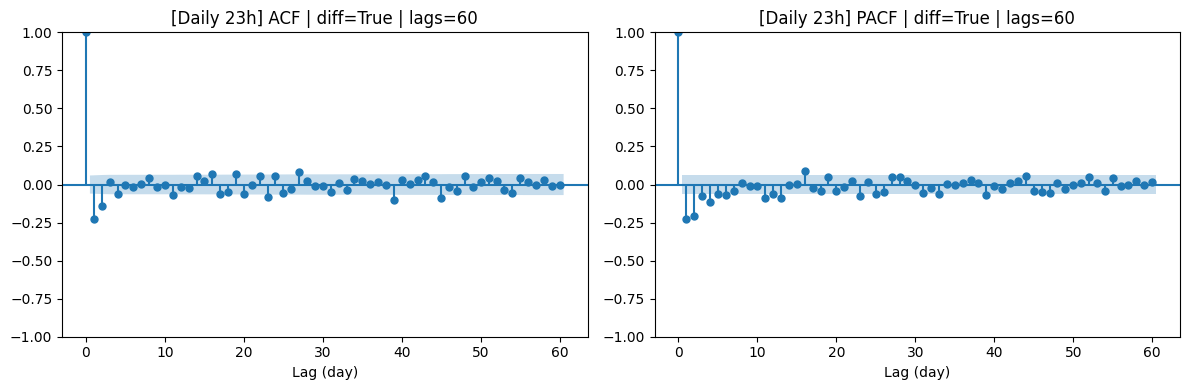

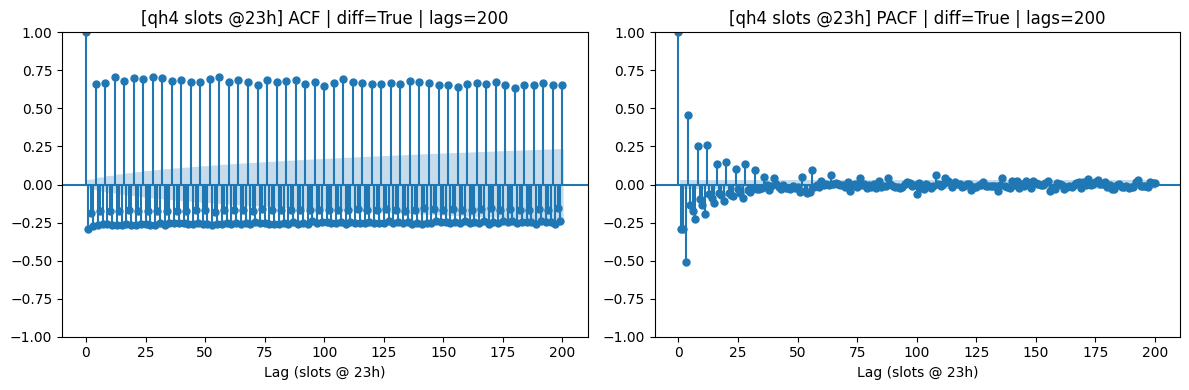

[INFO] lags clipped from 200 to 57 (n=116, pacf_cap <=(n//2-1) -> 57.


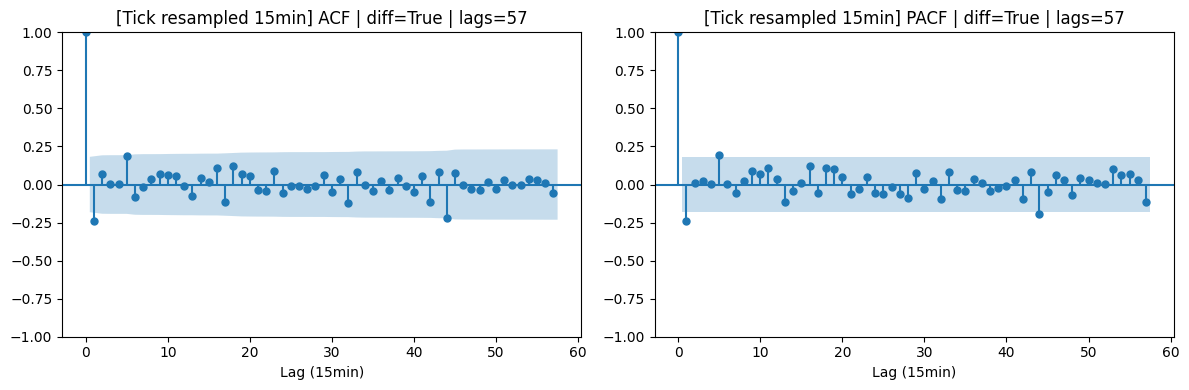

[INFO] Built ID series Fri23Q1 with 155 points
[INFO] lags clipped from 200 to 76 (n=154, pacf_cap <=(n//2-1) -> 76.


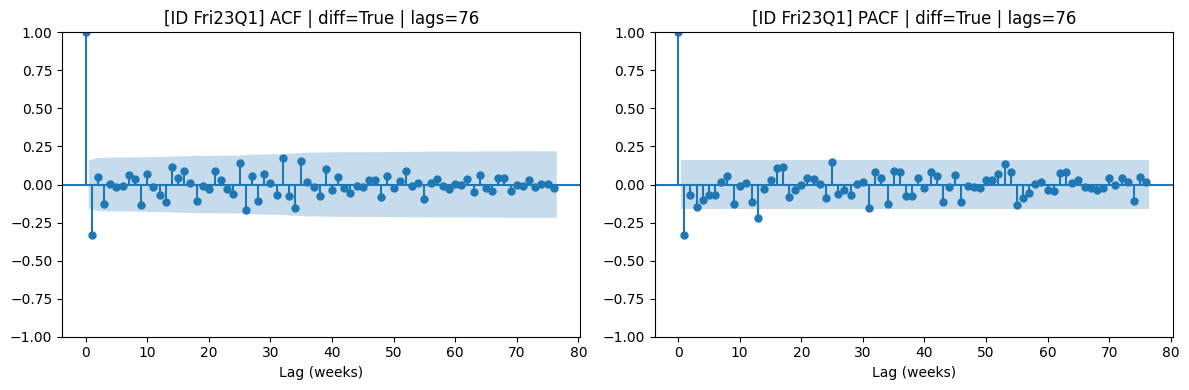

In [ ]:
# -*- coding: utf-8 -*-
"""
autocorr_electricity.py
------------------------------------------------
Layered autocorrelation analysis for electricity prices at three levels:
1) Daily representative prices (cross-day, lag in days)
2) 15-minute neighboring contracts (intraday, lag in 15min)
3) Individual contract transaction series (tick-level by ExecutionTime)

Expected columns in the input DataFrame:
- 'delivery_time' : timestamp of the contract delivery (datetime-like)
- 'ExecutionTime' : timestamp of execution/trade (datetime-like) [used for tick-level]
- 'close'         : price value (float)
"""

from __future__ import annotations

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Iterable, Optional, Tuple, Dict, Any
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# -----------------------------
# Utilities
# -----------------------------
def _ensure_datetime(df: pd.DataFrame,
                     cols: Iterable[str],
                     default_tz: str = "UTC") -> pd.DataFrame:
    """
    Ensure that the specified columns are datetime64[ns, tz], and align their timezones with the ExecutionTime column.

    1. Convert all to datetime (preserve existing tz).
    2. If ExecutionTime is already tz-aware → use its tz as the baseline.
    3. If ExecutionTime is naive → localize to default_tz (usually 'UTC').
    4. Other columns：
       - naive → localize to ExecutionTime’s tz
       - tz-aware → convert to ExecutionTime’s tz
    """
    out = df.copy()

    # Conver to datetime
    for c in cols:
        if c not in out.columns:
            raise KeyError(f"Column '{c}' not在 DataFrame 里.")
        if not pd.api.types.is_datetime64_any_dtype(out[c]):
            out[c] = pd.to_datetime(out[c], errors="coerce", utc=False)

    # Use ExecutionTime as the baseline
    if "ExecutionTime" not in cols:
        raise ValueError("ExecutionTime must be inclided in cols to be a baseline to align timezone")

    exec_col = out["ExecutionTime"]
    exec_tz = getattr(exec_col.dt, "tz", None)
    if exec_tz is None:
        # naive → localize to default_tz
        exec_tz = default_tz
        out["ExecutionTime"] = exec_col.dt.tz_localize(exec_tz, nonexistent="shift_forward", ambiguous="NaT")
    else:
        exec_tz = str(exec_tz)  # might be a tzinfo object, safer to cast to string

    # Align other columns to ExecutionTime's tz
    for c in cols:
        if c == "ExecutionTime":
            continue
        s = out[c]
        s_tz = getattr(s.dt, "tz", None)
        if s_tz is None:
            # naive → localize
            out[c] = s.dt.tz_localize(exec_tz, nonexistent="shift_forward", ambiguous="NaT")
        else:
            # tz-aware → convert
            out[c] = s.dt.tz_convert(exec_tz)

    return out



def check_regular_index(idx: pd.DatetimeIndex,
                        tol: pd.Timedelta = pd.Timedelta("1s")) -> Dict[str, Any]:
    """
    Check whether the datetime index is (approximately) regular.
    Returns a report dict with fields: is_regular, inferred_freq, n, stats, unique_deltas.
    """
    if len(idx) < 2:
        return {"is_regular": False, "inferred_freq": None, "n": len(idx),
                "stats": None, "unique_deltas": None}

    # differences in nanoseconds → TimedeltaIndex
    deltas_ns = np.diff(idx.view("int64"))
    deltas = pd.to_timedelta(deltas_ns, unit="ns")

    med = pd.to_timedelta(np.median(deltas))
    dev = np.abs(deltas - med)
    is_regular = bool((dev <= tol).all())

    vc = pd.Series(deltas).value_counts().sort_values(ascending=False)
    stats = {
        "min": deltas.min(),
        "max": deltas.max(),
        "median": med,
        "mean": pd.to_timedelta(deltas.mean()),
        "std": pd.to_timedelta(deltas.std())
    }
    return {
        "is_regular": is_regular,
        "inferred_freq": med,
        "n": len(idx),
        "stats": stats,
        "unique_deltas": vc
    }


def resample_series(y: pd.Series,
                    freq: str,
                    how: str = "last",
                    interpolate: bool = False) -> pd.Series:
    """
    Resample a time-indexed series to a regular grid.
    how: 'last'|'mean'|'first'|'ffill'
    interpolate: if True, uses .interpolate(limit_direction='both') after resampling
    """
    y = y.sort_index()
    if how == "ffill":
        rs = y.resample(freq).ffill()
    elif how in ("last", "mean", "first"):
        rs = getattr(y.resample(freq), how)()
    else:
        raise ValueError("how must be one of {'last','mean','first','ffill'}")
    if interpolate:
        rs = rs.interpolate(limit_direction='both')
    return rs


# -----------------------------
# Level 1: Daily representative price
# -----------------------------
def build_daily_series(df: pd.DataFrame,
                       hour: int = 23,
                       minutes: Tuple[int, ...] = (0,),   # include neighbors e.g. (0,15,30,45)
                       minute_agg: str = "median",        # aggregate within the hour across QHs
                       tz: Optional[str] = None) -> pd.Series:
    """
    Constructs a daily representative price series:
    For each calendar day, collect prices whose delivery_time falls on (hour, minutes),
    then aggregate them into one daily price (minute_agg).
    Returns a Series indexed by date (00:00 of day), values are float32.
    """
    df = _ensure_datetime(price_train, ['delivery_time', 'ExecutionTime'])

    m = (df['delivery_time'].dt.hour == hour) & (df['delivery_time'].dt.minute.isin(minutes))
    sub = df.loc[m, ['delivery_time', 'close']].dropna().copy()
    if sub.empty:
        raise ValueError("No rows matched the (hour, minutes) filter for daily series.")

    sub['date'] = sub['delivery_time'].dt.normalize()  # day key
    s = (sub.groupby('date')['close']
             .agg(minute_agg)
             .astype('float32')
             .sort_index())
    s.index.name = 'date'
    s.name = f'daily_{hour:02d}h_{minute_agg}'
    return s


# -----------------------------
# Level 2: 15-minute neighboring chain
# -----------------------------
def build_qh4_sequence(df: pd.DataFrame,
                       hour: int = 23,
                       tz: str | None = None,
                       agg: str = "median",
                       drop_incomplete_days: bool = True):
    """
    Only take the 4 quarter-hour slots (00/15/30/45) within the given hour of each day,
    sort by (date, slot), and build an equal-step sequence (no interpolation, no filling).
    Return:
      y: 1D Series (RangeIndex), values = close
      meta: DataFrame with (date, slot, close) for inspection/backtracking
    """
    need_cols = ['delivery_time','close']
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise KeyError(f"缺少列: {missing}")

    # Align timezone: align with ExecutionTime if it exists, otherwise only align delivery time
    cols = ['delivery_time'] + (['ExecutionTime'] if 'ExecutionTime' in df.columns else [])
    s = _ensure_datetime(df, cols, tz) if 'ExecutionTime' in df.columns else _ensure_datetime(df, ['delivery_time'], tz)

    m = (s['delivery_time'].dt.hour == hour) & (s['delivery_time'].dt.minute.isin([0,15,30,45]))
    sub = (s.loc[m, ['delivery_time','close']].dropna()
             .sort_values('delivery_time'))

    # If multiple rows have the same delivery_time, aggregate
    sub = (sub.groupby('delivery_time')['close']
             .agg({'last':'last','first':'first','mean':'mean','median':'median'}[agg])
             .reset_index())

    sub['date'] = sub['delivery_time'].dt.normalize()
    sub['slot'] = (sub['delivery_time'].dt.minute // 15).astype(int)  # 0,1,2,3

    if drop_incomplete_days:
        cnt = sub.groupby('date')['slot'].nunique()
        bad = cnt[cnt != 4].index
        if len(bad) > 0:
            print(f"[INFO] Dropping incomplete days: {len(bad)} days (fewer than 4 slots）")
            sub = sub[~sub['date'].isin(bad)]

    sub = sub.sort_values(['date','slot'])
    meta = sub[['date','slot','close']].reset_index(drop=True)
    y = pd.Series(meta['close'].to_numpy(), name=f"qh4_{hour:02d}h")
    return y, meta



# -----------------------------
# Level 3: Tick-level (ExecutionTime) for a specific contract (day + hour)
# -----------------------------
def build_contract_trade_series(df: pd.DataFrame,
                                day: str,
                                hour: int,
                                tz: Optional[str] = None) -> pd.Series:
    """
    Extracts the execution-time price series for the specific (day, hour, minute=0) contract.
    Returns a Series indexed by ExecutionTime, values are close.
    """
    df = _ensure_datetime(df, ['delivery_time', 'ExecutionTime'])

    target_date = pd.to_datetime(day).date()
    m = (
        (df['delivery_time'].dt.date == target_date) &
        (df['delivery_time'].dt.hour == hour) &
        (df['delivery_time'].dt.minute == 0) &
        (df['delivery_time'].dt.second == 0)
    )
    sub = (df.loc[m, ['ExecutionTime', 'close']]
             .dropna()
             .sort_values('ExecutionTime'))
    if sub.empty:
        raise ValueError("No trades found for the specified (day, hour).")

    y = pd.Series(sub['close'].to_numpy(),
                  index=sub['ExecutionTime'].to_numpy(),
                  name=f'contract_{day}_{hour:02d}:00')
    return y.astype('float32')
# -----------------------------
# Level 4: ID-level (delivery time) for aggregated contracts (weekday + hour + quarter)
# -----------------------------
def build_ID_series(df: pd.DataFrame,
                    id: str,
                    agg: str = "last",
                    tz: str | None = "UTC") -> pd.Series:
    """
    Build a representative series for a specific contract ID (e.g. Fri23Q1).
    Each point = one occurrence of that ID across time.
    Index = delivery_time, Values = close.
    """
    for c in ['delivery_time', 'ExecutionTime']:
        if not pd.api.types.is_datetime64_any_dtype(df[c]):
            df[c] = pd.to_datetime(df[c], utc=(tz=="UTC"), errors='coerce')

    sub = (df.loc[df['ID'] == id, ["delivery_time", "ExecutionTime", "close", "ID"]]
             .dropna()
             .sort_values(['delivery_time','ExecutionTime']))

    if agg == "last":
        s = sub.groupby('delivery_time')['close'].last()
    elif agg == "first":
        s = sub.groupby('delivery_time')['close'].first()
    elif agg == "mean":
        s = sub.groupby('delivery_time')['close'].mean()
    elif agg == "median":
        s = sub.groupby('delivery_time')['close'].median()
    else:
        raise ValueError("agg ∈ {'last','first','mean','median'}")

    s = s.astype('float32').sort_index()
    s.index.name = 'delivery_time'
    s.name = f'close_{id}_{agg}'
    print(f"[INFO] Built ID series {id} with {len(s)} points")
    return s


# -----------------------------
# ACF/PACF plotting
# -----------------------------
def acf_pacf(y: pd.Series,
             do_diff: bool = True,
             lags: Optional[int] = None,
             lags_frac: float = 1/3,
             pacf_method: str = "ywm",
             xlabel: str = "Lag",
             title_prefix: str = "",
             savepath: Optional[str] = None,
             show: bool = True) -> Dict[str, Any]:
    """
    Plot ACF and PACF with safe lag selection:
    - statsmodels' PACF (e.g., 'ywm','yw','ywmle','ols') requires nlags < n/2
    - We auto-cap lags to min(requested, n-2, floor(n/2)-1)
    """
    x = y.dropna()
    if do_diff:
        x = x.diff().dropna()
    n = len(x)
    if n < 5:
        raise ValueError(f"Too few points for ACF/PACF: n={n}")

    # user request or fraction
    req_lags = int(n * lags_frac) if (lags is None) else int(lags)

    # PACF safety cap: strictly less than n/2
    pacf_cap = max(1, (n // 2) - 1)  # floor(n/2) - 1
    # ACF safety cap: 至少要小于 n-1
    acf_cap = max(1, n - 2)

    used_lags = max(1, min(req_lags, pacf_cap, acf_cap))
    if used_lags < req_lags:
        print(f"[INFO] lags clipped from {req_lags} to {used_lags} "
              f"(n={n}, pacf_cap <=(n//2-1) -> {pacf_cap}.")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    plot_acf(x, lags=used_lags, ax=axes[0])
    axes[0].set_title(f"{title_prefix}ACF | diff={do_diff} | lags={used_lags}")
    axes[0].set_xlabel(xlabel)

    plot_pacf(x, lags=used_lags, ax=axes[1], method=pacf_method)
    axes[1].set_title(f"{title_prefix}PACF | diff={do_diff} | lags={used_lags}")
    axes[1].set_xlabel(xlabel)

    plt.tight_layout()
    if savepath:
        base, ext = os.path.splitext(savepath)
        out_path = f"{base}_acf_pacf.png"
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)
    return {"x": x, "lags": used_lags, "n": n}

def acf_pacf_ID_series(s: pd.Series,
                       lags: int = 52,  # set one year as default
                       do_diff: bool = True,
                       pacf_method: str = "ywm"):
    """
    Plot ACF/PACF for an ID-level series (weekly frequency).
    """
    x = s.copy()
    if do_diff:
        x = x.diff().dropna()

    n = len(x)
    use_lags = min(lags, n//2 - 1)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    plot_acf(x, lags=use_lags, ax=axes[0])
    axes[0].set_title(f"ACF ID {s.name} | diff={do_diff}")
    axes[0].set_xlabel("Lag (weeks)")

    plot_pacf(x, lags=use_lags, ax=axes[1], method=pacf_method)
    axes[1].set_title(f"PACF ID {s.name} | diff={do_diff}")
    axes[1].set_xlabel("Lag (weeks)")

    plt.tight_layout(); plt.show()
    return x


# -----------------------------
# High-level driver
# -----------------------------
def analyze_autocorrelation(df: pd.DataFrame,
                            level: str,
                            *,
                            hour: int = 23,
                            day: Optional[str] = None,
                            tz: Optional[str] = None,
                            include_neighbors: bool = True,
                            minute_agg: str = "median",
                            diff: bool = True,
                            lags: Optional[int] = None,
                            lags_frac: float = 1/3,
                            pacf_method: str = "ywm",
                            require_regular_tick: bool = True,
                            tick_tol: str = "1s",
                            resample_tick_freq: Optional[str] = None,
                            resample_tick_how: str = "last",
                            id_value: Optional[str] = None,
                            id_agg: str = "median",
                            savepath: Optional[str] = None,
                            show: bool = True) -> Dict[str, Any]:
    """
    level ∈ {'daily','qh15','tick'}
      - 'daily': cross-day daily representative price at given hour
      - 'qh15' : 15-min neighboring chain at the given hour (00/15/30/45)
      - 'tick' : single contract on a given day-hour using ExecutionTime
      - 'id': specific contract ID across occurrences (weekly cadence typical)
    Return:
    A dict with the built series, regularity report (if applicable), and ACF/PACF info.
    """
    level = level.lower().strip()
    if level not in {"daily", "qh15", "tick", "id"}:
        raise ValueError("level must be one of {'daily','qh15','tick'}.")

    # Build series
    if level == "daily":
        minutes = (0, 15, 30, 45) if include_neighbors else (0,)
        y = build_daily_series(df, hour=hour, minutes=minutes, minute_agg=minute_agg, tz=tz)
        xlabel = "Lag (day)"
        title_prefix = f"[Daily {hour:02d}h] "

        result = {"series": y, "regular_report": None}

    elif level == "qh15":
        y, meta = build_qh4_sequence(df, hour=hour, tz=tz, agg="median", drop_incomplete_days=True)
        xlabel = "Lag (slots @ {:02d}h)".format(hour)
        title_prefix = f"[qh4 slots @{hour:02d}h] "

        result = {"series": y, "meta": meta, "regular_report": None}


    elif level == 'tick':  # 'tick'
        if day is None:
            raise ValueError("For level='tick', you must provide 'day' (e.g., '2023-06-07').")
        y = build_contract_trade_series(df, day=day, hour=hour, tz=tz)

        # Regularity check on the raw tick series
        report = check_regular_index(y.index, tol=pd.Timedelta(tick_tol))
        if not report["is_regular"]:
            msg = (f"Irregular tick sampling detected: n={report['n']}, "
                   f"Δt median={report['stats']['median']}, "
                   f"min={report['stats']['min']}, max={report['stats']['max']}, tol={tick_tol}.")
            if require_regular_tick and resample_tick_freq is None:
                raise ValueError(msg + " Set 'resample_tick_freq' or set 'require_regular_tick=False'.")
            else:
                print("[WARN]", msg)

        # Optional resample to regular grid for tick-level ACF
        if resample_tick_freq:
            y = resample_series(y, resample_tick_freq, how=resample_tick_how, interpolate=True)
            xlabel = f"Lag ({resample_tick_freq})"
            title_prefix = f"[Tick resampled {resample_tick_freq}] "
        else:
            xlabel = "Lag (ticks)"
            title_prefix = "[Tick series] "

        result = {"series": y, "regular_report": report}

    else: # level='id'
      if not id_value:
        raise ValueError("For level='id', provide 'id_value' (e.g., 'Fri23Q1').")
      y = build_ID_series(df, id=id_value, agg=id_agg, tz=tz)

      # Simple cadence inference: check the median number of days between consecutive delivery_time values; if it is approximately 7, treat the series as weekly.
      diffs = y.index.to_series().sort_values().diff().dropna()
      median_days = diffs.dt.total_seconds().median() / 86400.0 if len(diffs) else None
      if median_days and abs(median_days - 7) < 1.0:
          xlabel = "Lag (weeks)"
          title_prefix = f"[ID {id_value}] "
      else:
          # “occurrences”
          xlabel = "Lag (occurrences)"
          title_prefix = f"[ID {id_value}] "

      result = {"series": y, "regular_report": None, "id_value": id_value, "median_spacing_days": median_days}


    # Plot ACF/PACF
    acf_info = acf_pacf(y, do_diff=diff, lags=lags, lags_frac=lags_frac,
                        pacf_method=pacf_method, xlabel=xlabel,
                        title_prefix=title_prefix, savepath=savepath, show=show)
    result["acf_pacf"] = acf_info
    return result


# -----------------------------
# Example
# -----------------------------
if __name__ == "__main__":

    # 1) Daily level (include neighbors 00/15/30/45 at 23:00, aggregate within-day by median)
    res_daily = analyze_autocorrelation(price_train, level="daily",
                                   hour=23, include_neighbors=True, minute_agg="median",
                                   tz="Europe/Berlin", diff=True, lags=60,
                                   savepath="daily_23h")

    # 2) 15-min level
    res_qh = analyze_autocorrelation(price_train, level="qh15",
                                   hour=23, include_neighbors=True,
                                   tz="Europe/Berlin", diff=True, lags=200,
                                   savepath="qh15_23h")

    # 3) Tick level (single contract), require regular or resample to 1min
    res_tick = analyze_autocorrelation(price_train, level="tick",
                                   day="2023-06-07", hour=23, tz="Europe/Berlin",
                                   require_regular_tick=False,
                                   resample_tick_freq="15min", resample_tick_how="last",
                                   diff=True, lags=200,
                                   savepath="tick_2023-06-07_23h")
    # 4）ID level (aggregated contracts)
    res_id = analyze_autocorrelation(price_train, level="id",
                                     id_value='Fri23Q1',   # ID specified
                                     id_agg="median",
                                     tz=None,
                                     diff=True,
                                     lags=200,
                                     pacf_method='ywm',
                                     savepath="id_Fri23Q1"
)
    pass


## MI

### feaature <-> target MI score

In [ ]:
df_train_2023_wide.head()

,tgt_close_t-12,tgt_volume_t-12,tgt_close_t-11,tgt_volume_t-11,tgt_close_t-10,tgt_volume_t-10,tgt_close_t-9,tgt_volume_t-9,tgt_close_t-8,tgt_volume_t-8,...,execution_hour,target_close,day_ahead_price,temperature_rounded,imported,exported,ExecutionTime,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m
0,-4.99,4.375,-7.99,3.375,-4.70,3.725,-7.30,0.800,-3.38,6.850,...,2023-01-01 03:00:00,-5.94,-29.93,11.1975,0.0,5619.0,2023-01-01 03:00:00,33406.0,2.0,36932.0
1,-8.20,5.850,-7.21,3.300,-6.84,1.700,-9.00,3.875,-7.44,8.925,...,2023-01-01 03:00:00,-1.80,-29.94,11.2650,0.0,5619.0,2023-01-01 03:00:00,33406.0,2.0,36932.0
2,-9.87,2.625,-9.89,2.775,-8.37,1.875,-3.71,3.425,-0.11,13.625,...,2023-01-01 03:00:00,NaN,-29.94,11.3325,0.0,5619.0,NaT,NaN,NaN,NaN
3,-5.00,0.000,-5.00,0.000,-1.64,0.300,-5.13,4.800,-2.00,7.200,...,2023-01-01 03:00:00,-5.23,-29.90,11.4000,0.0,4563.6,2023-01-01 03:00:00,33406.0,2.0,36932.0
4,-3.64,0.325,-3.80,2.075,-3.99,0.100,-3.83,4.000,NaN,NaN,...,2023-01-01 03:00:00,-2.28,-29.93,11.4625,0.0,4563.6,2023-01-01 03:00:00,33406.0,2.0,36932.0


(596506, 112)
Columns (sample): ['tgt_close_t-12', 'tgt_close_t-11', 'tgt_close_t-10', 'tgt_close_t-9', 'tgt_close_t-8', 'tgt_close_t-7', 'tgt_close_t-6', 'tgt_close_t-5', 'tgt_close_t-4', 'tgt_close_t-3', 'tgt_close_t-2', 'tgt_close_t-1']
#candidate features: 12
['neigh1_close_t-12', 'neigh1_close_t-11', 'neigh1_close_t-10', 'neigh1_close_t-9', 'neigh1_close_t-8', 'neigh1_close_t-7', 'neigh1_close_t-6', 'neigh1_close_t-5', 'neigh1_close_t-4', 'neigh1_close_t-3', 'neigh1_close_t-2', 'neigh1_close_t-1'] ...


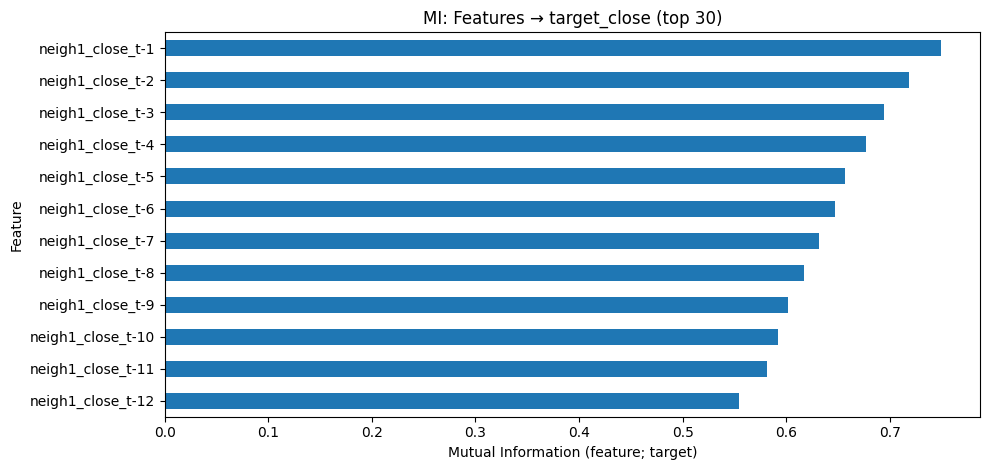

Elbow index = 4, selected features = 5
['neigh1_close_t-1', 'neigh1_close_t-2', 'neigh1_close_t-3', 'neigh1_close_t-4', 'neigh1_close_t-5'] ...


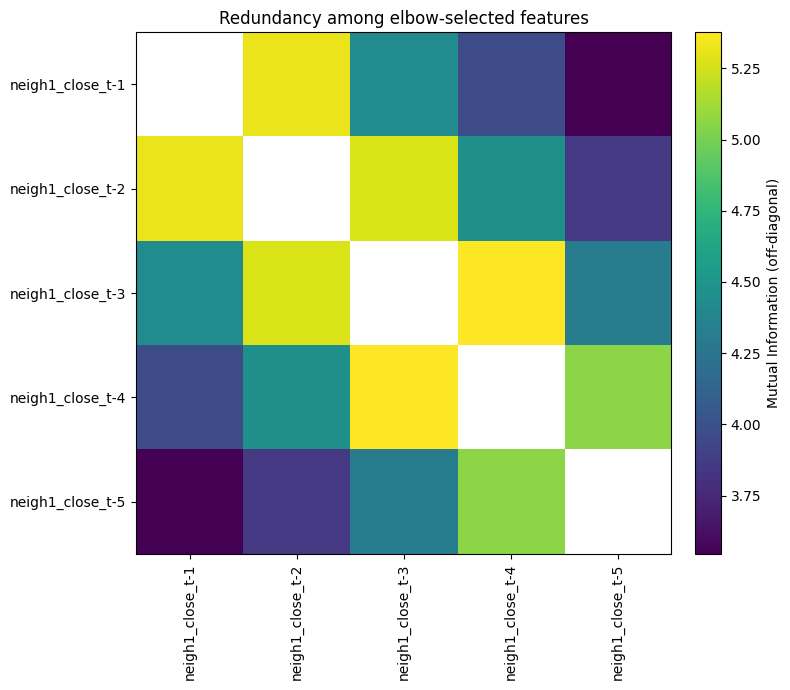

In [ ]:
# ============================================
# Config (edit here)
# ============================================
PARQUET_PATH = ("/content/df_filled_with_full_variables.parquet") # features in groups
TARGET_COL   = "target_close"

# Columns to DROP from candidate features (only those existing will be dropped)
DROP_COLS = [
    "target_close",            # target itself
    "delivery_time",           # timestamp-like
    "execution_hour",          # timestamp-like
]

# Only include features matching these prefixes (leave [] to include all non-dropped, non-target columns)
# For Dataset 1, you could set ["tgt_close_t-"].
# FEATURE_INCLUDE_PREFIXES = ["tgt_close_t-"]
# For Dataset 2, you may leave empty to take everything except drops, or list prefixes of interest.
FEATURE_INCLUDE_PREFIXES = ["neigh1_"]

# (Optional) Exclude features matching these prefixes (applied after include)
FEATURE_EXCLUDE_PREFIXES = []  # e.g., ["debug_", "leaky_"]

# MI / plotting / output
N_NEIGHBORS  = 3
BIN_STRATEGY = "quantile"   # {'quantile','uniform'}
N_BINS_X     = 10
RANDOM_STATE = 42

SAVE_DIR     = "figs"
SAVE_FIGS    = True
SAVE_TABLES  = True
TOP_K_PLOT   = 30

# Optional redundancy heatmap among elbow-selected features
DO_REDUNDANCY_HEATMAP = True   # set True to also compute pairwise MI heatmap for selected features

# ============================================
# Load data
# ============================================
import numpy as np
import pandas as pd
from pathlib import Path

df = df_train_2023_wide.copy()
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

print(df.shape)
print("Columns (sample):", df.columns[:12].tolist())
assert TARGET_COL in df.columns, f"TARGET_COL='{TARGET_COL}' not in df"

# ============================================
# Helpers
# ============================================
from typing import List, Optional
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

def _is_binary(series: pd.Series) -> bool:
    """True if the column is binary (two unique values) or boolean."""
    return (series.dropna().nunique() == 2) or (series.dtype == bool)

def _elbow_index(sorted_vals: np.ndarray) -> int:
    """
    Elbow via max distance to the line between first and last point.
    Input must be a descending array. Returns elbow index (inclusive).
    """
    if len(sorted_vals) < 3:
        return max(0, len(sorted_vals) - 1)
    x = np.arange(len(sorted_vals), dtype=float)
    y = sorted_vals.astype(float)
    p1 = np.array([x[0], y[0]])
    p2 = np.array([x[-1], y[-1]])
    vec = p2 - p1
    denom = np.linalg.norm(vec)
    if denom == 0:
        return 0
    dirv = vec / denom

    dmax, imax = -1.0, 0
    for i in range(len(y)):
        pi = np.array([x[i], y[i]])
        proj_len = np.dot(pi - p1, dirv)
        proj_point = p1 + proj_len * dirv
        dist = np.linalg.norm(pi - proj_point)
        if dist > dmax:
            dmax, imax = dist, i
    return int(imax)

def plot_mi_bar(series: pd.Series,
                top: Optional[int] = None,
                title: str = "MI: Features → Target (descending)",
                savepath: Optional[str] = None,
                dpi: int = 300):
    """Horizontal bar chart of MI(feature; target)."""
    s = series if top is None else series.iloc[:top]
    plt.figure(figsize=(10, max(3, 0.4 * len(s))))
    s[::-1].plot(kind="barh")
    plt.xlabel("Mutual Information (feature; target)")
    plt.ylabel("Feature")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()

def pairwise_mi_matrix(df: pd.DataFrame,
                       cols: List[str],
                       bin_strategy: str = "quantile",
                       n_bins_x: int = 10,
                       average_symmetric: bool = True,
                       random_state: int = 42) -> pd.DataFrame:
    """
    Symmetric MI among selected columns.
    - continuous↔continuous: mutual_info_regression both directions; averaged if requested.
    - mixed or discrete↔discrete: discretize then mutual_info_score.
    """
    cols = [c for c in cols if c in df.columns]
    n = len(cols)
    M = np.zeros((n, n), dtype=float)

    disc_cache = {}
    is_cont = {}
    for c in cols:
        s = df[c]
        if _is_binary(s) or pd.api.types.is_categorical_dtype(s):
            fill = s.mode().iloc[0] if s.notna().any() else 0
            disc_cache[c] = pd.factorize(s.fillna(fill))[0]
            is_cont[c] = False
        else:
            est = KBinsDiscretizer(n_bins=n_bins_x, encode='ordinal', strategy=bin_strategy)
            disc_cache[c] = est.fit_transform(s.values.reshape(-1,1)).astype(int).ravel()
            is_cont[c] = True

    for i in range(n):
        ci = cols[i]
        xi = df[ci].values.reshape(-1, 1)
        for j in range(i, n):
            cj = cols[j]
            if i == j:
                M[i, j] = mutual_info_score(disc_cache[ci], disc_cache[cj])  # entropy proxy
                continue

            if is_cont[ci] and is_cont[cj]:
                mij1 = mutual_info_regression(xi, df[cj].values, discrete_features=False, random_state=random_state)[0]
                mij2 = mutual_info_regression(df[cj].values.reshape(-1,1), df[ci].values,
                                              discrete_features=False, random_state=random_state)[0]
                mij = (mij1 + mij2) / 2.0 if average_symmetric else mij1
                M[i, j] = M[j, i] = mij
            else:
                mij = mutual_info_score(disc_cache[ci], disc_cache[cj])
                M[i, j] = M[j, i] = mij

    return pd.DataFrame(M, index=cols, columns=cols)

def plot_heatmap(matrix: pd.DataFrame,
                 title: str = "Mutual Information (redundancy)",
                 figsize=(8, 7),
                 savepath: Optional[str] = None,
                 dpi: int = 300,
                 vmin: Optional[float] = None,
                 vmax: Optional[float] = None,
                 cmap: str = "viridis",
                 mask_diag: bool = True):
    """
    Matplotlib heatmap for MI redundancy.
    - Masks the diagonal by default (self-information ≠ redundancy).
    - If vmin/vmax are not given, derives them from off-diagonal entries only.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    M = matrix.copy()

    # Mask or zero-out the diagonal to avoid misleading “self redundancy”
    if mask_diag:
        np.fill_diagonal(M.values, np.nan)

    # If no vmin/vmax provided, set them from off-diagonal data only
    if vmin is None or vmax is None:
        vals = M.values.flatten()
        offdiag_vals = vals[~np.isnan(vals)]
        if offdiag_vals.size > 0:
            if vmin is None: vmin = np.nanmin(offdiag_vals)
            if vmax is None: vmax = np.nanmax(offdiag_vals)

    plt.figure(figsize=figsize)
    im = plt.imshow(M.values, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("Mutual Information (off-diagonal)", rotation=90)
    plt.xticks(range(M.shape[1]), M.columns, rotation=90)
    plt.yticks(range(M.shape[0]), M.index)
    plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()



# ============================================
# Build candidate feature set (generalized)
# ============================================
# Logic:
# 1) Start from all columns.
# 2) Remove TARGET + DROP_COLS that exist.
# 3) If FEATURE_INCLUDE_PREFIXES is non-empty: keep only columns starting with any prefix.
# 4) Exclude FEATURE_EXCLUDE_PREFIXES (if any).
# Works for Dataset 1 (lags only) and Dataset 2 (mixed features).

all_cols = df.columns.tolist()
drops = [c for c in DROP_COLS if c in df.columns]
blocked = set(drops + [TARGET_COL])

candidates = [c for c in all_cols if c not in blocked]

if FEATURE_INCLUDE_PREFIXES:
    kept = []
    for c in candidates:
        if any(c.startswith(pfx) for pfx in FEATURE_INCLUDE_PREFIXES):
            kept.append(c)
    candidates = kept

if FEATURE_EXCLUDE_PREFIXES:
    candidates = [c for c in candidates if not any(c.startswith(pfx) for pfx in FEATURE_EXCLUDE_PREFIXES)]

assert len(candidates) > 0, "No candidate features after filtering."
print(f"#candidate features: {len(candidates)}")
print(candidates[:20], "...")

# ============================================
# Compute MI(feature; target)
# ============================================
X = df[candidates].values
y = df[TARGET_COL].values
discrete_mask = np.array([_is_binary(df[c]) for c in candidates], dtype=bool)

mi_vals = mutual_info_regression(
    X, y,
    discrete_features=discrete_mask,
    n_neighbors=N_NEIGHBORS,
    random_state=RANDOM_STATE
)
mi_series = pd.Series(mi_vals, index=candidates, name=f"MI_to_{TARGET_COL}").sort_values(ascending=False)

if SAVE_TABLES:
    mi_series.to_csv(Path(SAVE_DIR) / "mi_series.csv", header=True)

plot_mi_bar(
    series=mi_series,
    top=TOP_K_PLOT,
    title=f"MI: Features → {TARGET_COL} (top {TOP_K_PLOT})",
    savepath=str(Path(SAVE_DIR) / f"mi_bar_top{TOP_K_PLOT}.png") if SAVE_FIGS else None
)

k = _elbow_index(mi_series.values)
elbow_feats = list(mi_series.index[:k+1])
print(f"Elbow index = {k}, selected features = {len(elbow_feats)}")
print(elbow_feats[:25], "...")
if SAVE_TABLES:
    Path(SAVE_DIR, "elbow_features.txt").write_text("\n".join(elbow_feats), encoding="utf-8")

# ============================================
#  Redundancy among elbow-selected features
# ============================================
if DO_REDUNDANCY_HEATMAP:
    M_selected = pairwise_mi_matrix(
        df=df,
        cols=elbow_feats,
        bin_strategy=BIN_STRATEGY,
        n_bins_x=N_BINS_X,
        average_symmetric=True,
        random_state=RANDOM_STATE
    )
    if SAVE_TABLES:
        M_selected.to_csv(Path(SAVE_DIR) / "redundancy_selected.csv")

    plot_heatmap(
        matrix=M_selected,
        title="Redundancy among elbow-selected features",
        figsize=(8,7),
        savepath=str(Path(SAVE_DIR) / "redundancy_selected.png") if SAVE_FIGS else None,
        dpi=300
    )
else:
    print("Redundancy heatmap skipped (set DO_REDUNDANCY_HEATMAP=True to enable).")


In [ ]:
# ============================================
# Config for features redundancy analysis
# ============================================
OUTDIR = "/content"          # where to save CSVs/figures
DO_PLOTS = True                      # set False to skip plots
N_JOBS = -1                          # joblib parallelism (-1 uses all cores)
SHOW_PROGRESS = True                 # tqdm progress bar
RANDOM_STATE = 42

# MI estimation mode for pairwise matrices:
# - "fast": discretize all and use mutual_info_score (symmetric, fastest; good for redundancy)
# - "auto": cont↔cont uses kNN MI (both directions averaged), else discrete MI
# - "cont_approx": cont↔cont uses single-direction kNN MI (approx symmetric; faster than "auto")
METHOD_INTRA = "fast"
METHOD_CROSS = "fast"

# Discretization settings (used by "fast" and mixed cases)
BIN_STRATEGY = "quantile"            # {'quantile', 'uniform'}
N_BINS_X = 15

# Representative feature strategy per group:
# - "entropy_max": pick the column with highest (discretized) self-entropy within the group
# - "mi_to_target": pick the column with the highest MI to TARGET_COL
REP_STRATEGY = "mi_to_target"
TARGET_COL = "target_close"          # required if REP_STRATEGY == "mi_to_target"

# ============================================
# Dependencies and lightweight fallbacks
# ============================================
import os
from typing import Optional, List, Dict, Union, Sequence, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# joblib & tqdm are optional but recommended
try:
    from joblib import Parallel, delayed
except Exception:
    Parallel = None
    delayed = None

try:
    from tqdm import tqdm
except Exception:
    tqdm = None

# ============================================
# Core MI: pairwise matrix with flexible modes
# ============================================
def pairwise_mi_features(
    df: pd.DataFrame,
    cols: Optional[List[str]] = None,
    groups: Optional[Dict[str, Union[List[str], str]]] = None,
    indices: Optional[Sequence[int]] = None,
    average_symmetric: bool = True,
    *,
    method: str = "auto",           # "auto" | "fast" | "cont_approx"
    n_jobs: int = -1,
    show_progress: bool = True,
    row_subsample: Optional[int] = None,
    random_state: Optional[int] = None,
    n_bins_x: int = 10,
    bin_strategy: str = "quantile"
) -> pd.DataFrame:
    """
    Compute a symmetric pairwise MI matrix among selected columns.

    Selection
    ---------
    - cols: list of column names (optional)
    - groups: dict group_name -> [cols...] (optional)
    - indices: integer indices into df.columns (optional)
    If nothing provided, use all df columns.

    Estimation modes
    ----------------
    - "fast": discretize all variables, then use mutual_info_score (symmetric). Fast and robust for redundancy.
    - "auto": continuous↔continuous uses kNN MI both directions (averaged if average_symmetric=True);
              otherwise, discretize and use mutual_info_score.
    - "cont_approx": like "auto" but for continuous↔continuous compute a single direction kNN MI (approx symmetric).

    Performance
    -----------
    - n_jobs: parallel upper-triangle computation via joblib (if available).
    - row_subsample: randomly subsample rows to trade accuracy for speed.
    - show_progress: tqdm progress bar if available.

    Returns
    -------
    pd.DataFrame (n x n) with MI values, indexed by column names.
    """
    rng = np.random.default_rng(random_state)

    # ---- choose columns ----
    if cols is None:
        cols = []
    if groups:
        for g in groups.values():
            cols.extend([g] if isinstance(g, str) else list(g))
    if indices is not None:
        cols.extend([df.columns[i] for i in indices])
    if not cols:
        cols = df.columns.tolist()

    cols = [c for c in cols if c in df.columns]
    cols = list(dict.fromkeys(cols))  # dedupe, keep order
    n = len(cols)
    if n == 0:
        return pd.DataFrame()

    df_local = df[cols].copy()

    # ---- optional row subsample ----
    if row_subsample is not None and row_subsample < len(df_local):
        sampled_idx = rng.choice(df_local.index.values, size=row_subsample, replace=False)
        df_local = df_local.loc[sampled_idx]

    # ---- type flags & NaN fill ----
    is_cat_like = {}
    for c in cols:
        s = df_local[c]
        # treat binary/boolean/categorical as discrete
        if pd.api.types.is_categorical_dtype(s) or s.dropna().isin([0, 1]).all() or s.dtype == bool:
            is_cat_like[c] = True
            if s.isna().any():
                mode_val = s.mode().iloc[0] if s.notna().any() else 0
                df_local[c] = s.fillna(mode_val)
        else:
            is_cat_like[c] = False
            if s.isna().any():
                med = s.median() if s.notna().any() else 0.0
                df_local[c] = s.fillna(med)

    is_cont = {c: not is_cat_like[c] for c in cols}
    is_constant = {c: (df_local[c].nunique(dropna=True) <= 1) for c in cols}

    # ---- discretization cache (for "fast" or mixed cases) ----
    disc_cache = {}
    for c in cols:
        s = df_local[c].values
        if is_cont[c]:
            est = KBinsDiscretizer(n_bins=n_bins_x, encode='ordinal', strategy=bin_strategy)
            disc = est.fit_transform(s.reshape(-1, 1)).astype(int).ravel()
        else:
            disc = pd.factorize(pd.Series(s))[0]
        disc_cache[c] = disc

    # ---- continuous caches ----
    cont_cache = {c: df_local[c].values.reshape(-1, 1) for c in cols if is_cont[c]}
    flat_cache = {c: df_local[c].values for c in cols}

    # ---- upper-triangle pairs ----
    pairs = [(i, j) for i in range(n) for j in range(i, n)]

    def _pair_mi(i, j):
        ci, cj = cols[i], cols[j]

        # diagonal: entropy proxy on discretized variable
        if i == j:
            if is_constant[ci]:
                return (i, j, 0.0)
            return (i, j, mutual_info_score(disc_cache[ci], disc_cache[cj]))

        # any constant -> 0 redundancy
        if is_constant[ci] or is_constant[cj]:
            return (i, j, 0.0)

        # fast: all discrete MI
        if method == "fast":
            return (i, j, mutual_info_score(disc_cache[ci], disc_cache[cj]))

        # cont-cont
        if is_cont[ci] and is_cont[cj]:
            xi = cont_cache[ci]
            yj = flat_cache[cj]
            if method == "cont_approx" or not average_symmetric:
                mij = mutual_info_regression(
                    xi, yj, discrete_features=False, random_state=random_state
                )[0]
                return (i, j, mij)
            else:
                mij1 = mutual_info_regression(
                    xi, yj, discrete_features=False, random_state=random_state
                )[0]
                yx = cont_cache[cj]
                ti = flat_cache[ci]
                mij2 = mutual_info_regression(
                    yx, ti, discrete_features=False, random_state=random_state
                )[0]
                return (i, j, 0.5 * (mij1 + mij2))

        # otherwise (at least one discrete): discrete MI
        return (i, j, mutual_info_score(disc_cache[ci], disc_cache[cj]))

    iterator = pairs
    if show_progress and tqdm is not None:
        iterator = tqdm(pairs, desc="Computing pairwise MI", unit="pair")

    # parallel map if joblib is available
    if Parallel is not None and delayed is not None and n_jobs != 1:
        results = Parallel(n_jobs=n_jobs, prefer="threads")(
            delayed(_pair_mi)(i, j) for (i, j) in iterator
        )
    else:
        results = [_pair_mi(i, j) for (i, j) in iterator]

    M = np.zeros((n, n), dtype=float)
    for i, j, val in results:
        M[i, j] = val
        M[j, i] = val
    return pd.DataFrame(M, index=cols, columns=cols)


# ============================================
# Grouping: map feature columns into groups
# ============================================
def build_groups(all_cols: List[str]) -> Dict[str, List[str]]:
    """
    Build feature groups from Dataset 2 naming conventions.
    Only keep columns that exist in the dataframe.
    Adjust the patterns here to match your exact column names.
    """
    def exist(candidates: List[str]) -> List[str]:
        return [c for c in candidates if c in all_cols]

    # Lagged target & neighbor contracts
    groups: Dict[str, List[str]] = {
        "tgt_close": exist([f"tgt_close_t-{j}"  for j in range(1, 13)]),
        "neigh1":    exist([f"neigh1_close_t-{j}" for j in range(1, 13)]),
        "neigh2":    exist([f"neigh2_close_t-{j}" for j in range(1, 13)]),
        "neigh3":    exist([f"neigh3_close_t-{j}" for j in range(1, 13)]),
    }

    # Actuals (e.g., exc-15m, and 1-day-aligned minutes)
    for v in ["wind", "solar", "load"]:
        base = f"{v}_actual"
        lst = exist([f"{base}_exc-15m"]) + exist([f"{base}_t-1d-{m}" for m in ["0m","15m","30m","45m","60m"]])
        if lst:
            groups[f"{v}_actual"] = lst

    # Forecasts (intrahour + 1-day lagged intrahour)
    for v in ["wind", "solar", "load"]:
        base = f"{v}_forecast"
        lst = exist([f"{base}_t-{m}" for m in ["0m","15m","30m","45m","60m"]]) + \
              exist([f"{base}_t-1d-{m}" for m in ["0m","15m","30m","45m","60m"]])
        if lst:
            groups[f"{v}_forecast"] = lst

    # Other exogenous / time features (customize as needed)
    others = exist([
        "day_ahead_price",
        "delivery_month_sin","delivery_month_cos",
        "delivery_hour_sin","delivery_hour_cos",
        "delivery_weekday_sin","delivery_weekday_cos",
        "day_of_year_sin","day_of_year_cos",
        "time_to_expiry_h","temperature_rounded",
        "exported","imported"
    ])
    if others:
        groups["others"] = others

    # Drop empty groups
    groups = {g: cols for g, cols in groups.items() if len(cols) > 0}
    return groups

# ============================================
# Group-level redundancy + representatives
# ============================================
def group_redundancy_and_representatives(
    df: pd.DataFrame,
    groups: Dict[str, List[str]],
    *,
    method: str = "fast",
    rep_strategy: str = "entropy_max",    # "entropy_max" | "mi_to_target"
    target_col: Optional[str] = None,
    n_jobs: int = -1,
    show_progress: bool = True,
    random_state: Optional[int] = 42,
    n_bins_x: int = 15,
    bin_strategy: str = "quantile"
) -> Tuple[Dict[str, pd.DataFrame], pd.DataFrame, Dict[str, str]]:
    """
    For each group:
      - compute an intra-group MI matrix (pairwise)
      - compute summary stats (mean / max off-diagonal MI)
      - select a representative feature per group
    Returns:
      group_mats, group_stats (DataFrame), representatives (dict)
    """
    group_mats: Dict[str, pd.DataFrame] = {}
    stats_rows = []
    representatives: Dict[str, str] = {}

    for g, cols in groups.items():
        cols = [c for c in cols if c in df.columns]
        if len(cols) == 0:
            continue

        if len(cols) == 1:
            col = cols[0]
            M = pd.DataFrame([[0.0]], index=[col], columns=[col])
            group_mats[g] = M
            representatives[g] = col
            stats_rows.append({
                "group": g, "n_features": 1, "rep_feature": col,
                "rep_strategy": rep_strategy, "mean_offdiag_mi": 0.0, "max_offdiag_mi": 0.0
            })
            continue

        M = pairwise_mi_features(
            df=df, cols=cols, method=method,
            n_jobs=n_jobs, show_progress=show_progress,
            random_state=random_state, n_bins_x=n_bins_x, bin_strategy=bin_strategy
        )
        group_mats[g] = M

        # off-diagonal stats
        vals = M.values
        iu = np.triu_indices_from(vals, k=1)
        offdiag = vals[iu]
        mean_mi = float(np.nanmean(offdiag)) if offdiag.size else 0.0
        max_mi = float(np.nanmax(offdiag)) if offdiag.size else 0.0

        # representative selection
        if rep_strategy == "entropy_max":
            entropy = np.diag(vals)  # self-entropy on discretized variables
            rep_idx = int(np.argmax(entropy))
            rep_feature = M.index[rep_idx]
        elif rep_strategy == "mi_to_target":
            if not target_col or target_col not in df.columns:
                raise ValueError("rep_strategy='mi_to_target' requires a valid target_col in df.")
            M_target = pairwise_mi_features(
                df=df, cols=cols + [target_col], method=method,
                n_jobs=n_jobs, show_progress=False,
                random_state=random_state, n_bins_x=n_bins_x, bin_strategy=bin_strategy
            )
            target_mis = M_target.loc[cols, target_col].values
            rep_idx = int(np.argmax(target_mis))
            rep_feature = cols[rep_idx]
        else:
            raise ValueError("rep_strategy must be 'entropy_max' or 'mi_to_target'.")

        representatives[g] = rep_feature
        stats_rows.append({
            "group": g, "n_features": len(cols), "rep_feature": rep_feature,
            "rep_strategy": rep_strategy, "mean_offdiag_mi": mean_mi, "max_offdiag_mi": max_mi
        })

    group_stats = pd.DataFrame(stats_rows).sort_values(["mean_offdiag_mi"], ascending=False).reset_index(drop=True)
    return group_mats, group_stats, representatives


# ============================================
# Cross-group redundancy among representatives
# ============================================
def cross_group_redundancy(
    df: pd.DataFrame,
    representatives: Dict[str, str],
    *,
    method: str = "fast",
    n_jobs: int = -1,
    show_progress: bool = True,
    random_state: Optional[int] = 42,
    n_bins_x: int = 15,
    bin_strategy: str = "quantile"
) -> pd.DataFrame:
    """
    Pairwise MI among representative features.
    Returns a matrix whose rows/columns are group names.
    """
    rep_cols = list(representatives.values())
    M = pairwise_mi_features(
        df=df, cols=rep_cols, method=method,
        n_jobs=n_jobs, show_progress=show_progress,
        random_state=random_state, n_bins_x=n_bins_x, bin_strategy=bin_strategy
    )
    # Rename axes to group names
    idx_map = {v: k for k, v in representatives.items()}
    M = M.rename(index=idx_map, columns=idx_map)
    return M


# ============================================
# Plotting helper (matplotlib only; neutral defaults)
# ============================================
def plot_heatmap(matrix: pd.DataFrame, title: str, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    im = plt.imshow(matrix.values, aspect="auto", interpolation="nearest")
    plt.xticks(ticks=np.arange(matrix.shape[1]), labels=matrix.columns, rotation=90)
    plt.yticks(ticks=np.arange(matrix.shape[0]), labels=matrix.index)
    plt.title(title)
    plt.colorbar(label="MI")
    plt.tight_layout()
    plt.show()


Computing pairwise MI: 100%|██████████| 66/66 [00:03<00:00, 18.93pair/s]


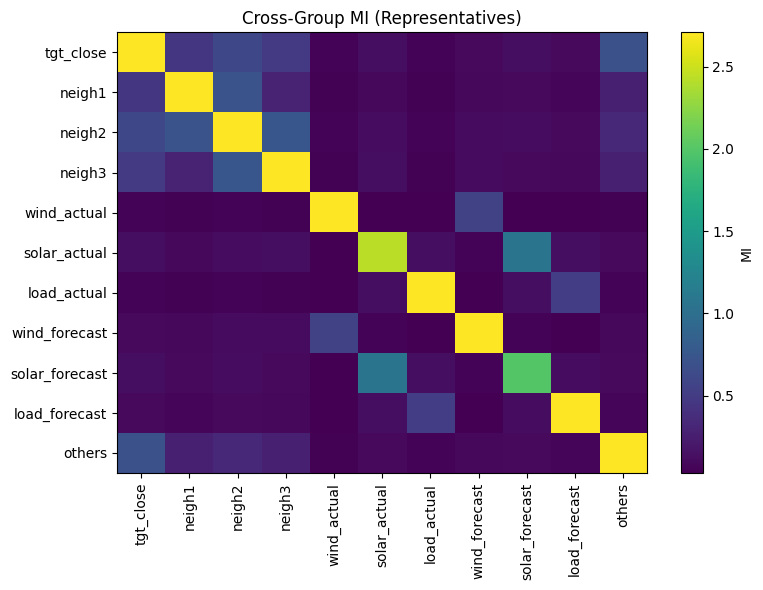

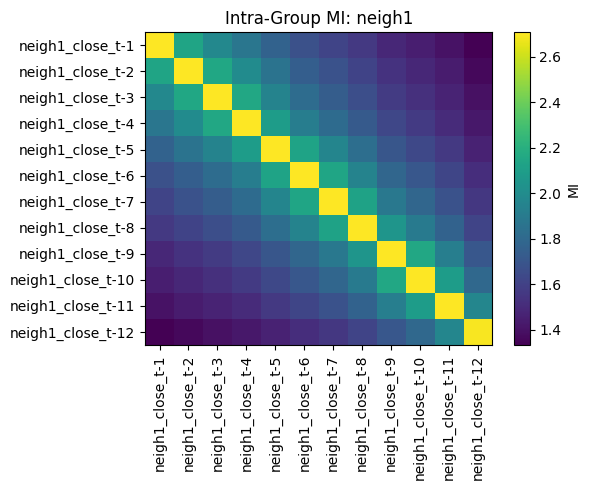

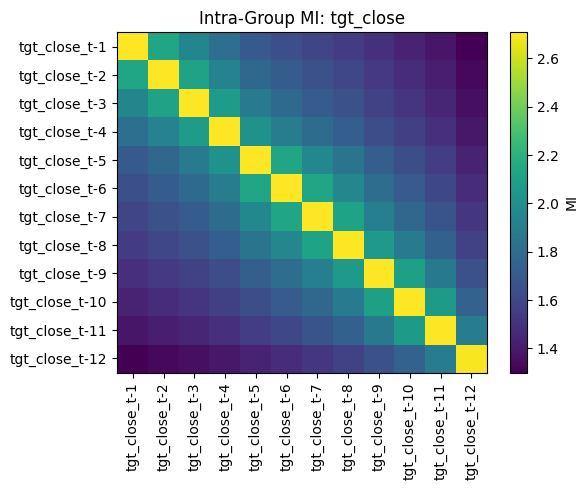

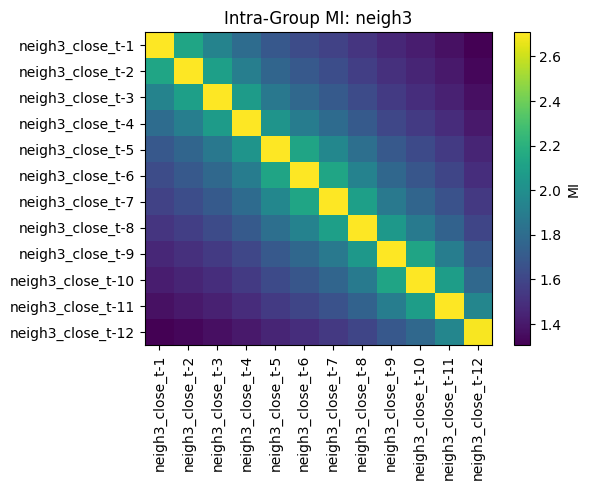

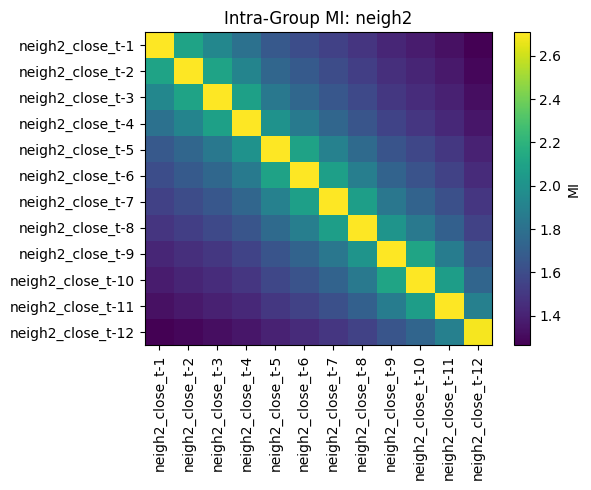


Representatives per group:
{'tgt_close': 'tgt_close_t-1', 'neigh1': 'neigh1_close_t-1', 'neigh2': 'neigh2_close_t-1', 'neigh3': 'neigh3_close_t-1', 'wind_actual': 'wind_actual_exc-15m', 'solar_actual': 'solar_actual_t-1d-0m', 'load_actual': 'load_actual_t-1d-0m', 'wind_forecast': 'wind_forecast_t-0m', 'solar_forecast': 'solar_forecast_t-30m', 'load_forecast': 'load_forecast_t-15m', 'others': 'day_ahead_price'}

Top 10 groups by mean off-diagonal MI:


,group,n_features,rep_feature,rep_strategy,mean_offdiag_mi,max_offdiag_mi
0,neigh1,12,neigh1_close_t-1,mi_to_target,1.743047,2.156116
1,tgt_close,12,tgt_close_t-1,mi_to_target,1.720438,2.126281
2,neigh3,12,neigh3_close_t-1,mi_to_target,1.713821,2.128363
3,neigh2,12,neigh2_close_t-1,mi_to_target,1.675943,2.109054
4,wind_actual,6,wind_actual_exc-15m,mi_to_target,1.523796,2.309924
5,load_actual,6,load_actual_t-1d-0m,mi_to_target,1.196765,2.015314
6,solar_forecast,10,solar_forecast_t-30m,mi_to_target,1.183594,1.535380
7,load_forecast,10,load_forecast_t-15m,mi_to_target,1.165176,2.060163
8,wind_forecast,10,wind_forecast_t-0m,mi_to_target,1.093506,2.378104
9,solar_actual,6,solar_actual_t-1d-0m,mi_to_target,0.978772,1.671985



Cross-group MI matrix (representatives):


,tgt_close,neigh1,neigh2,neigh3,wind_actual,solar_actual,load_actual,wind_forecast,solar_forecast,load_forecast,others
tgt_close,2.708033,0.452216,0.604985,0.478795,0.050099,0.126824,0.050719,0.100116,0.126416,0.091899,0.692724
neigh1,0.452216,2.708036,0.710517,0.291089,0.048288,0.086426,0.049323,0.087410,0.101946,0.080106,0.267653
neigh2,0.604985,0.710517,2.708026,0.742294,0.054982,0.116195,0.052942,0.105340,0.120258,0.098692,0.324373
neigh3,0.478795,0.291089,0.742294,2.708028,0.049405,0.123665,0.048985,0.106006,0.099573,0.085393,0.264686
wind_actual,0.050099,0.048288,0.054982,0.049405,2.708013,0.038171,0.032608,0.542423,0.037916,0.028697,0.047337
solar_actual,0.126824,0.086426,0.116195,0.123665,0.038171,2.432526,0.129472,0.054440,1.064432,0.124500,0.100278
load_actual,0.050719,0.049323,0.052942,0.048985,0.032608,0.129472,2.708028,0.033937,0.126948,0.514387,0.051275
wind_forecast,0.100116,0.087410,0.105340,0.106006,0.542423,0.054440,0.033937,2.708041,0.059674,0.038210,0.089566
solar_forecast,0.126416,0.101946,0.120258,0.099573,0.037916,1.064432,0.126948,0.059674,1.991974,0.116039,0.101317
load_forecast,0.091899,0.080106,0.098692,0.085393,0.028697,0.124500,0.514387,0.038210,0.116039,2.708041,0.075928


In [ ]:
# ============================================
# Pipeline runner (Dataset 2)
# Assumes `df` exists and includes TARGET_COL
# ============================================
def run_redundancy_pipeline_ds2(
    df: pd.DataFrame,
    outdir: str = OUTDIR,
    *,
    method_intra: str = METHOD_INTRA,
    method_cross: str = METHOD_CROSS,
    rep_strategy: str = REP_STRATEGY,
    target_col: Optional[str] = TARGET_COL,
    n_jobs: int = N_JOBS,
    show_progress: bool = SHOW_PROGRESS,
    random_state: int = RANDOM_STATE,
    n_bins_x: int = N_BINS_X,
    bin_strategy: str = BIN_STRATEGY,
    do_plots: bool = DO_PLOTS
) -> Dict[str, Union[pd.DataFrame, Dict[str, pd.DataFrame]]]:
    os.makedirs(outdir, exist_ok=True)

    # 1) Build groups from available columns
    groups = build_groups(df.columns.tolist())

    # 2) Intra-group MI & representatives
    group_mats, group_stats, representatives = group_redundancy_and_representatives(
        df, groups,
        method=method_intra,
        rep_strategy=rep_strategy,
        target_col=target_col,
        n_jobs=n_jobs,
        show_progress=show_progress,
        random_state=random_state,
        n_bins_x=n_bins_x,
        bin_strategy=bin_strategy
    )

    # Save each group's matrix & stats
    for g, M in group_mats.items():
        M.to_csv(os.path.join(outdir, f"intra_{g}_mi_matrix.csv"))
    group_stats.to_csv(os.path.join(outdir, "group_intra_stats.csv"), index=False)

    # 3) Cross-group MI among representatives
    M_cross = cross_group_redundancy(
        df, representatives,
        method=method_cross,
        n_jobs=n_jobs,
        show_progress=show_progress,
        random_state=random_state,
        n_bins_x=n_bins_x,
        bin_strategy=bin_strategy
    )
    M_cross.to_csv(os.path.join(outdir, "cross_group_mi_matrix.csv"))

    # 4) Cross-group edges (upper triangle) for ranking/network plotting
    cross_edges = (
        M_cross.stack()
               .reset_index()
               .rename(columns={"level_0": "group_i", "level_1": "group_j", 0: "mi"})
    )
    cross_edges = cross_edges[cross_edges["group_i"] < cross_edges["group_j"]].reset_index(drop=True)
    cross_edges.sort_values("mi", ascending=False).to_csv(
        os.path.join(outdir, "cross_group_edges.csv"), index=False
    )

    # 5) Optional plots
    if do_plots:
        plot_heatmap(M_cross, title="Cross-Group MI (Representatives)", figsize=(8, 6))
        top_groups = group_stats.sort_values("mean_offdiag_mi", ascending=False)["group"].head(4)
        for g in top_groups:
            plot_heatmap(group_mats[g], title=f"Intra-Group MI: {g}", figsize=(6, 5))

    return {
        "groups": groups,
        "group_mats": group_mats,
        "group_stats": group_stats,
        "representatives": representatives,
        "M_cross": M_cross,
        "cross_edges": cross_edges
    }

# ============================================
# Run (example)
# df must be your Dataset 2 DataFrame; ensure TARGET_COL exists
# ============================================
filled = pd.read_parquet("/content/df_filled_with_full_variables.parquet", engine='pyarrow')
df = filled.copy()
assert TARGET_COL in df.columns, f"TARGET_COL='{TARGET_COL}' not found in df"


results = run_redundancy_pipeline_ds2(
    df=filled, # Dataset with features
    # outdir=OUTDIR,
    method_intra=METHOD_INTRA,
    method_cross=METHOD_CROSS,
    rep_strategy=REP_STRATEGY,
    target_col=TARGET_COL,
    n_jobs=N_JOBS,
    show_progress=SHOW_PROGRESS,
    random_state=RANDOM_STATE,
    n_bins_x=N_BINS_X,
    bin_strategy=BIN_STRATEGY,
    do_plots=DO_PLOTS
)

print("\nRepresentatives per group:")
print(results["representatives"])
print("\nTop 10 groups by mean off-diagonal MI:")
display(results["group_stats"].head(10))
print("\nCross-group MI matrix (representatives):")
display(results["M_cross"])